<a href="https://colab.research.google.com/github/ksb7762-k/Dart-B/blob/main/kaggle3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##HousePrices 회귀 분석  

안녕하세요!  

이것은 제가 처음으로 만든 노트북입니다. 이 대회의 여러 노트북을 공부한 후, 회귀 분석의 기본적인 전체 과정을 정리해 보았습니다. 이 커널에서는 다음과 같은 내용을 소개합니다.  

EDA(탐색적 데이터 분석)부터 시작하여 데이터를 탐색하는 과정은 분석에서 가장 중요한 단계입니다. 각 변수의 타입을 정의하고, 변수의 형태를 파악하며 이를 시각화하는 방법을 소개합니다.  

그다음 피처 엔지니어링 단계에서는 EDA 결과를 바탕으로 이상치 처리, 결측값 처리, 파생 변수 생성, 변수 변환 등 각 변수에 대한 전처리 작업을 수행합니다.  

이후 최적화 단계에서는 모델이 복잡해질수록 필요해지는 하이퍼파라미터 설정 방법을 다룹니다. 하이퍼파라미터 조합은 모델 성능에 큰 영향을 줄 수 있기 때문에, GridSearchCV와 Optuna를 사용해 하이퍼파라미터를 최적화하는 방법을 소개합니다.  

마지막으로 모델링 단계에서는 회귀 분석에 활용할 수 있는 기본 모델들을 생성하고 학습합니다. Lasso와 Ridge 같은 선형 회귀 모델은 물론, SVM과 몇 가지 트리 기반 알고리즘을 활용하며, 다양한 모델을 조합하는 스태킹(Stacking) 기법을 통해 일반화 성능을 극대화할 예정입니다.  

# 모듈 불러오기

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 5000) # 처음에 max_columns라고 입력해서 "Pattern matched multiple keys" 오류 메시지 발생함. 정확한 전체 옵션 기입
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('darkgrid')
from scipy.stats import norm,skew,probplot # 정규분호, 왜도 계산, QQplot등의 통계함수
from scipy.special import boxcox1p  # 박스콕스 변환 함수(정규성 향상에 사용)
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import DBSCAN

import optuna
from functools import partial

# 🔍 SciPy란?

SciPy는 Scientific Python의 줄임말로, 과학 및 공학 계산을 위한 파이썬 라이브러리임.  
기초 수학 연산을 제공하는 NumPy 위에 구축되어 있으며, 고급 통계, 최적화, 적분, 선형대수, 신호 처리 등 다양한 기능을 포함함.  
복잡한 수학/과학적 문제를 빠르고 정확하게 해결할 수 있게 해줌.

---

## 📦 주요 모듈 및 기능

| 모듈명              | 기능 설명 |
|--------------------|-----------|
| `scipy.stats`      | 확률 분포, 통계량 계산, 가설 검정 등 |
| `scipy.optimize`   | 함수 최적화, 방정식 풀이 |
| `scipy.integrate`  | 수치 적분, 미분 방정식 풀이 |
| `scipy.linalg`     | 고급 선형대수 연산 |
| `scipy.fft`        | 푸리에 변환 (FFT) |
| `scipy.signal`     | 신호 처리, 필터링 |
| `scipy.spatial`    | 거리 계산, 공간 알고리즘 (KD-트리 등) |
| `scipy.special`    | 감마 함수, 베셀 함수 등 특수 함수 |

---


# 🤖 Scikit-learn (sklearn) 이란?

**Scikit-learn**은 파이썬에서 머신러닝을 위한 대표적인 라이브러리 중 하나임.  
약칭은 `sklearn`이고, **단순하고 효율적인 데이터 마이닝과 머신러닝 도구**들을 제공함.

## ⚙️ 제공하는 기능들

| 기능 범주         | 주요 도구/기능 예시 |
|------------------|---------------------|
| **전처리**        | StandardScaler, LabelEncoder, OneHotEncoder 등 |
| **특성 선택**     | SelectKBest, RFE, PCA 등 |
| **모델 선택/검증**| train_test_split, GridSearchCV, cross_val_score 등 |
| **분류(Classification)** | LogisticRegression, RandomForestClassifier 등 |
| **회귀(Regression)** | LinearRegression, Ridge, SVR 등 |
| **클러스터링**     | KMeans, DBSCAN, AgglomerativeClustering 등 |
| **앙상블**        | Bagging, Boosting, Stacking 등 |
| **파이프라인**     | Pipeline, FeatureUnion 등 |

---



# ⚙️ Scikit-learn 전처리 도구 비교

다섯 가지 주요 전처리 도구들의 **차이점**과 **사용 목적**을 표와 함께 정리함.

---

## 📊 기능 요약 비교표

| 도구 이름             | 주요 역할                              | 작동 방식                                 | 주요 사용 상황 |
|----------------------|----------------------------------------|------------------------------------------|----------------|
| `StandardScaler`     | 데이터 **표준화**                      | 평균 0, 표준편차 1로 스케일링             | 정규분포 가정 모델 (SVM, 선형모델 등) |
| `RobustScaler`       | **이상치에 강한** 표준화               | 중앙값 기준, IQR(사분위 범위)로 나눔       | 이상치가 많은 경우 |
| `PolynomialFeatures` | **다항 특성 생성**                     | x → x, x², x³, x₁·x₂ 등으로 확장           | 비선형 관계 학습용 |
| `OneHotEncoder`      | 범주형 → **원-핫 인코딩**               | 각 범주마다 0과 1의 컬럼 생성              | 범주형 독립변수 처리 |
| `LabelEncoder`       | 범주형 → **숫자 레이블 인코딩**         | 카테고리 → 0, 1, 2처럼 정수로 변환         | 목표변수(라벨)가 문자열일 때 주로 사용 |

---

## 🔍 개별 설명

### 1. `StandardScaler`
- 모든 데이터를 평균 0, 표준편차 1로 스케일링
- 데이터가 정규분포를 따른다는 가정을 하는 모델에 적합
- 이상치가 있으면 영향을 크게 받을 수 있음
- **각 열(컬럼)마다 독립적으로 스케일링**함
### 2. `RobustScaler`
- 중앙값(median)과 IQR(사분위 범위)를 사용하여 스케일링
- 이상치의 영향을 최소화함
- 정규분포 여부와 무관하게 안정적으로 작동

### 3. `PolynomialFeatures`
- 기존 피처들을 조합하거나 제곱, 세제곱 등 다항식 형태로 확장
- 선형 모델도 복잡한 비선형 관계를 학습할 수 있게 만듦

### 4. `OneHotEncoder`
- 범주형 변수를 0과 1로 이루어진 이진 벡터로 변환
- 예: ['red', 'blue', 'green'] → [1,0,0], [0,1,0], [0,0,1]
- 트리 기반 모델 외 대부분의 모델에서 유용함

### 5. `LabelEncoder`
- 범주형 변수에 숫자 인덱스를 부여 (문자열 → 정수)
- 예: ['dog', 'cat', 'mouse'] → [0, 1, 2]
- 단, 이 인코딩은 순서가 생기므로 피처에 사용할 때는 주의

---

## ✅ 정리

- `StandardScaler`, `RobustScaler` → 수치형 데이터를 스케일링할 때 사용
- `PolynomialFeatures` → 비선형 관계를 모델에 반영하고 싶을 때 사용
- `OneHotEncoder`, `LabelEncoder` → 범주형 데이터를 숫자로 바꿀 때 사용


# ⚠️ LabelEncoder 사용 시 모델에 순서가 영향을 주는지 파악하는 방법

## 3. 영향을 파악하는 방법

### ✅ 실험적 접근
① 동일한 데이터를 기준으로 두 가지 버전 생성:
- A: LabelEncoder 사용
- B: OneHotEncoder 사용

LabelEncoder의 성능이 눈에 띄게 떨어진다면, 순서 문제로 인한 왜곡이 생긴 것임

# 데이터 로딩

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/kagglestudy/housing price prediction/train (1).csv')
test = pd.read_csv('/content/drive/MyDrive/kagglestudy/housing price prediction/test (2).csv')

In [ ]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
print(f'train size:{train.shape}')
print(f'test size: {test.shape}')

train size:(1460, 81)
test size: (1459, 80)


# EDA

##  종속 변수 탐색
먼저 종속 변수를 이해하려고 시도했습니다.
종속 변수의 정규성(normality) 을 판단하기 위해 왜도(skewness) 와 첨도(kurtosis) 를 계산하고,
히스토그램(histogram) 과 QQ plot을 그려 보았습니다.

✅ 정규성(Normality)이란?
정규성이란, 변수의 분포가 정규분포(normal distribution) 를 따른다는 것을 의미합니다.
정규성을 가장 쉽게 확인하는 방법은 히스토그램과 QQ plot을 그려보는 것입니다.

히스토그램이 종 모양(bell shape) 을 띄는 것이 이상적입니다.

또한, 왜도(skewness) 와 첨도(kurtosis) 값을 함께 확인하면 이해에 도움이 됩니다.

QQ plot에서 오른쪽 위 방향으로 기준선과 함께 뻗어나가는 모양이 보이면, 데이터가 정규성을 가진다고 볼 수 있습니다.   

⚠️데이터가 정규성을 따르지 않는다면,  
로그 변환(log transformation) 또는 박스콕스(Box-Cox) 변환과 같은 방식으로 변환할 수 있습니다.

In [ ]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

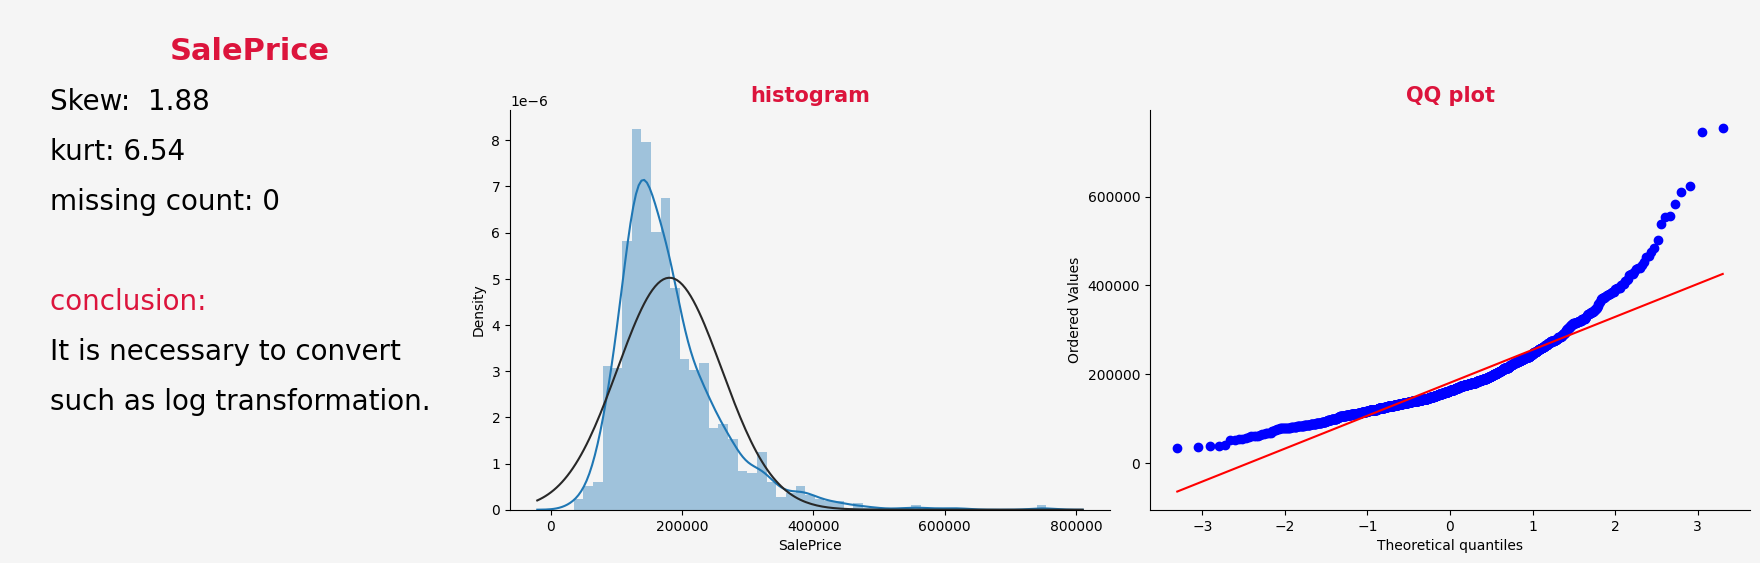

In [ ]:
f = plt.figure(facecolor = 'whitesmoke', figsize=(20,5))
ax_left = f.add_axes([0,0, .2,1], facecolor='whitesmoke')
ax_left.axis('off')
ax_left.text(.4,.9, 'SalePrice', color='crimson', size=22, weight='bold')
ax_left.text(.1, .8, f'Skew: {train.SalePrice.skew(): .2f}', size=20)
ax_left.text(.1,.7, f'kurt: {train.SalePrice.kurt() :.2f}',size=20)
ax_left.text(.1, .6, f'missing count: {train.SalePrice.isnull().sum()}', size=20)
ax_left.text(.1, .4, 'conclusion: ',color='crimson', size=20)
ax_left.text(.1,.3, 'It is necessary to convert', size=20)
ax_left.text(.1, .2, 'such as log transformation.', size=20)

ax_right1 = f.add_axes([0.25, 0,.3,.8], facecolor='whitesmoke')
sns.distplot(train.SalePrice, fit=norm, ax=ax_right1)
ax_right1.spines[['top', 'right']].set_visible(False)
ax_right1.set_title('histogram', color='crimson', weight='bold', size=15)

ax_right2 = f.add_axes([.57,0,.3,.8], facecolor='whitesmoke')
probplot(train.SalePrice, plot=ax_right2)
ax_right2.spines[['top','right']].set_visible(False)
ax_right2.set_title('QQ plot', color='crimson', weight='bold', size = 15)

plt.show()


# 🎨 facecolor vs colormap 차이

| 항목        | facecolor                         | colormap (cmap)                          |
|-------------|-----------------------------------|------------------------------------------|
| 의미        | 배경색, 면의 색                   | 데이터 값에 따라 자동으로 색을 지정하는 색상 맵 |
| 적용 대상   | 도화지, 축, 박스 등               | 히트맵, 산점도, 이미지, 등고선 등         |
| 지정 방식   | `'white'`, `'gray'`, `'crimson'` 등 | `'viridis'`, `'plasma'`, `'coolwarm'` 등  |
| 사용 예시   | `plt.figure(facecolor='white')`   | `plt.scatter(x, y, c=z, cmap='viridis')` |
| 용도        | 시각화 구성의 배경 꾸미기 용도     | 수치 값 표현을 색상으로 시각화할 때 사용  |

---



# 🔢 [0, 0, 0.2, 1] 의미 해석 (matplotlib add_axes)

형식: `[x0, y0, width, height]`

- `x0 = 0` → **왼쪽 경계**부터 시작 (도화지의 가장 왼쪽)
- `y0 = 0` → **아래쪽 경계**부터 시작 (도화지의 맨 아래)
- `width = 0.2` → 도화지 너비의 **20%**
- `height = 1` → 도화지 높이의 **100%**

즉, 도화지의 **왼쪽 20%를 세로로 꽉 채운 영역**에 축(Axes)이 생성됨.

---



# 🤔 데이터가 정규분포가 아닌데, 왜 정규분포에 'fit' 시키는가?

---

## ✅ 핵심 개념

> 정규분포에 '끼워맞춘다'는 게 아니라  
> **"이 데이터가 정규분포를 따른다고 가정했을 때, 얼마나 잘 맞는가?"** 를 보기 위한 분석 과정이에요.

---

## 📌 목적은 '진단'이지 '강제 변환'이 아님

| 오해 ❌ | 실제 ✅ |
|--------|--------|
| 데이터를 정규분포로 억지로 바꾸는 것 | 정규분포 **곡선과 비교**해서 얼마나 비슷한지 확인하는 것 |

---

# 📊 `distplot`에서 `kde` 곡선 vs `fit=norm` 곡선 비교

---

## ✅ 둘 다 **곡선**을 그려주지만, 의미가 다름!

| 구분 | KDE 곡선 | `fit=norm` 정규분포 곡선 |
|------|-----------|--------------------------|
| 모양 | 데이터 기반 부드러운 곡선 | 정규분포 형태 (종 모양) |
| 기준 | 실제 데이터 분포 | 정규분포로 근사 |
| 계산 방법 | 커널 밀도 추정 (Kernel Density Estimation) | MLE로 평균/표준편차 추정 |
| 목적 | 데이터의 실제 밀도 추정 | 정규분포와 얼마나 유사한지 보기 위한 비교용 |

---


## 🎯 KDE vs MLE 차이 정리

| 항목 | KDE (커널 밀도 추정) | MLE (최대우도추정) |
|------|----------------------|---------------------|
| 목적 | 데이터의 실제 분포를 부드럽게 표현 | 주어진 분포의 최적 파라미터 추정 |
| 기반 | **데이터 그 자체** | **가정된 분포 모델** |
| 결과 | 곡선 (PDF 추정) | 평균, 표준편차 등 수치 |
| 시각화 | 데이터 모양 그대로 | 모델 기준 정규곡선 등 |
| 사용 예 | KDE plot, Seaborn의 `kde=True` | `norm.fit()`, `fit=정규분포` |

---

# 이해가 잘 안가요

# 2. 독립변수 탐색 - 유형 정의


변수들을 범주형 변수와 수치형 변수로 분류하였습니다.
변수에 대한 설명을 읽고 변수의 유형을 판단한 뒤, 파생 변수 생성이나 데이터 변환에 대한 아이디어를 도출할 수 있습니다.

변수 유형은 다음과 같이 분류됩니다.

1. 범주형 변수

- 명목형 변수

- 순서형 변수

2. 수치형 변수

- 구간형 변수

- 비율형 변수

탐색 및 전처리 방식은 변수의 유형에 따라 결정됩니다.

Pandas를 사용하시면 변수의 데이터 타입(예: 수치형 타입, 객체형)을 확인하실 수 있습니다.
하지만 모든 수치형 변수가 반드시 연속형 변수라고 단정지을 수는 없습니다.
따라서 저는 data_description 파일을 참고하여 주관적으로 변수들을 분류하였습니다.

이제 수치형 변수와 객체형 변수를 확인해보시기 바랍니다.


In [ ]:
num_vars = train.columns[train.dtypes != 'object']
obj_vars = train.columns[train.dtypes == 'object']

print('\nNumerical vars: ')
print(num_vars.values)
print('\nObjet vars: ')
print(obj_vars.values)


Numerical vars: 
['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice']

Objet vars: 
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'Pave

하지만 MSSubClass 변수는 명목형 변수임을 확인할 수 있습니다.
또한 OverallQual, OverallCond, 그리고 Year, Month 변수는 순서형 변수임을 확인하실 수 있습니다.  

# 3. 독립변수 탐색 - 결측치 확인

In [ ]:
df = pd.DataFrame({
    'A': [1, 2, 3],
    'B': [4, 5, 6]
})
df

,A,B
0,1,4
1,2,5
2,3,6


shape[0]은 튜플의 행(row)의 개수  
shape[1]은 열(column)의 개수

In [ ]:
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)  # train과 test 데이터를 합치고 SalePrice 컬럼은 제거함

cnt_missing = all_data.isnull().sum().sort_values(ascending=False)

cnt_percent = cnt_missing / all_data.shape[0] * 100  # 전체 행 수 대비 결측값 비율(%)을 계산함

missing_table = pd.DataFrame([cnt_missing, cnt_percent],             # 결측 개수와 비율을 하나의 데이터프레임으로 만들고
                             index=['missing count', 'missing percent']).T
missing_table

,missing count,missing percent
PoolQC,2909.0,99.657417
MiscFeature,2814.0,96.402878
Alley,2721.0,93.216855
Fence,2348.0,80.438506
MasVnrType,1766.0,60.500171
...,...,...
EnclosedPorch,0.0,0.000000
MiscVal,0.0,0.000000
MoSold,0.0,0.000000
YrSold,0.0,0.000000


In [ ]:
missing_table = missing_table[missing_table['missing count'] > 0]
missing_table = missing_table.reset_index()
missing_table['missing count'] = missing_table['missing count'].astype(int)

missing_table.head(10)

,index,missing count,missing percent
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,MasVnrType,1766,60.500171
5,FireplaceQu,1420,48.646797
6,LotFrontage,486,16.649538
7,GarageYrBlt,159,5.447071
8,GarageCond,159,5.447071
9,GarageFinish,159,5.447071


<Axes: xlabel='missing percent', ylabel='index'>

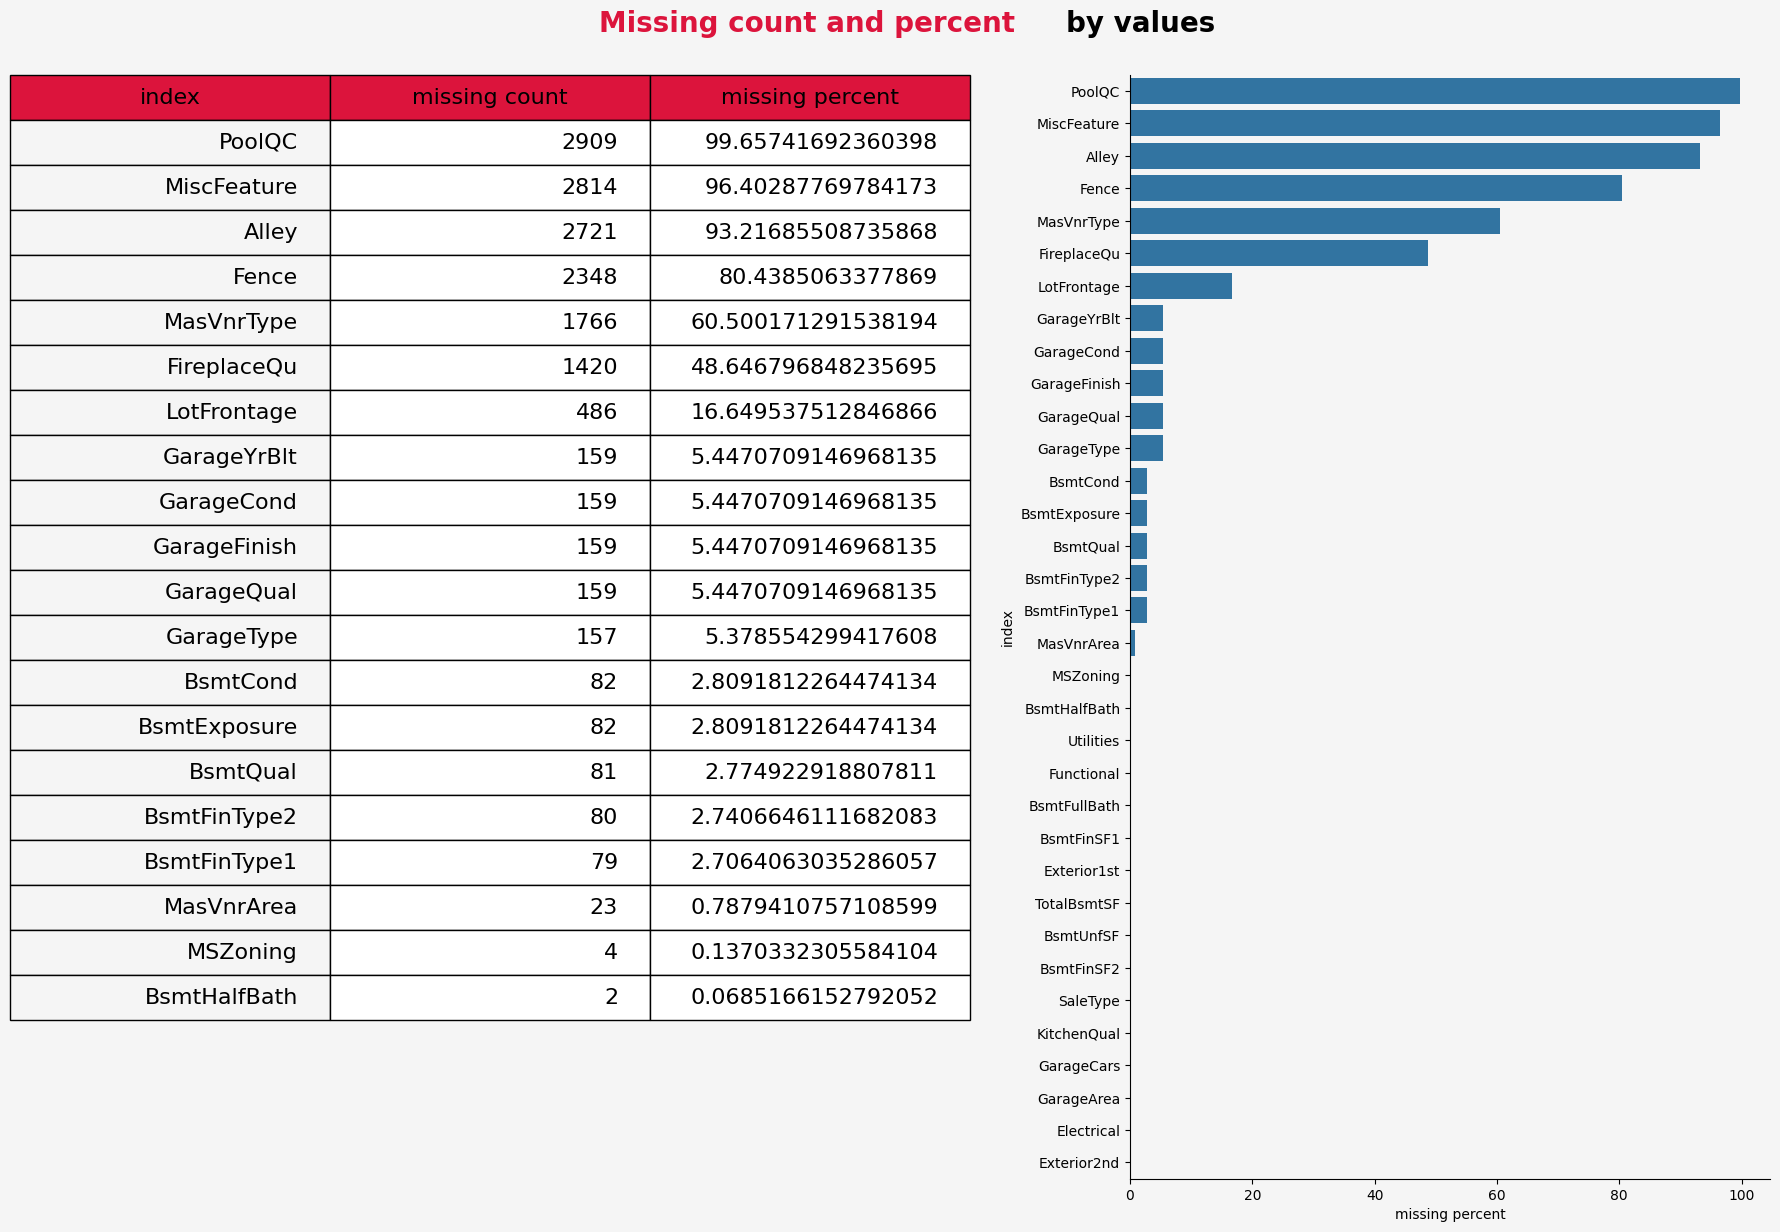

In [ ]:
color_list = [['whitesmoke', 'white', 'white']]

fig= plt.figure(facecolor = 'whitesmoke')
ax1 = fig.add_axes([0,0,1,0.1])
ax2 = fig.add_axes([1.5, -2.3, 1, 2.3], facecolor = 'whitesmoke')
ax2.spines[['top', 'right']].set_visible(False)  # ax2의 상단/우측 테두리선 숨기기, `spines`는 **matplotlib의 축(ax)** 에서 **테두리 선(border line)** 을 의미

ax1.set_axis_off() # ax1(테이블 영역)의 축과 눈금 제거
table = ax1.table(cellText = missing_table.values[:20], colLabels = missing_table.columns,
                   colColours=['crimson']*3, cellColours=color_list*20)
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1.5,2.7)
ax1.text(0.67, .9, 'Missing count and percent', color = 'crimson', fontsize=20, fontweight = 'bold')
ax1.text(1.4, .9, 'by values', fontsize=20, fontweight = 'bold')

sns.barplot(y=missing_table['index'], x=missing_table['missing percent'], orient = 'h', ax=ax2) # `orient`는 시각화할 차트의 방향(orientation)을 지정하는 인자 "v" → vertical, "h" → horizontal

# ✅ 2. `cellText`, `colLabels`는 뭐예요?

이건 `matplotlib.axes.Axes.table()` 함수의 **공식 매개변수**입니다.

| 인자 이름    | 의미 |
|--------------|------|
| `cellText`   | 테이블에 넣을 데이터 값 (2차원 리스트 또는 넘파이 배열) |
| `colLabels`  | 열(column) 이름 리스트 |
| `cellColours`| 셀별 배경색 (2차원 리스트) |
| `colColours` | 열 이름 셀의 배경색 리스트 |

많은 변수들에 결측값이 존재하고 몇몇의 변수들은 극도로 많은 결측값이 존재합니다  

# 4. 독립변수 탐색 - 분포

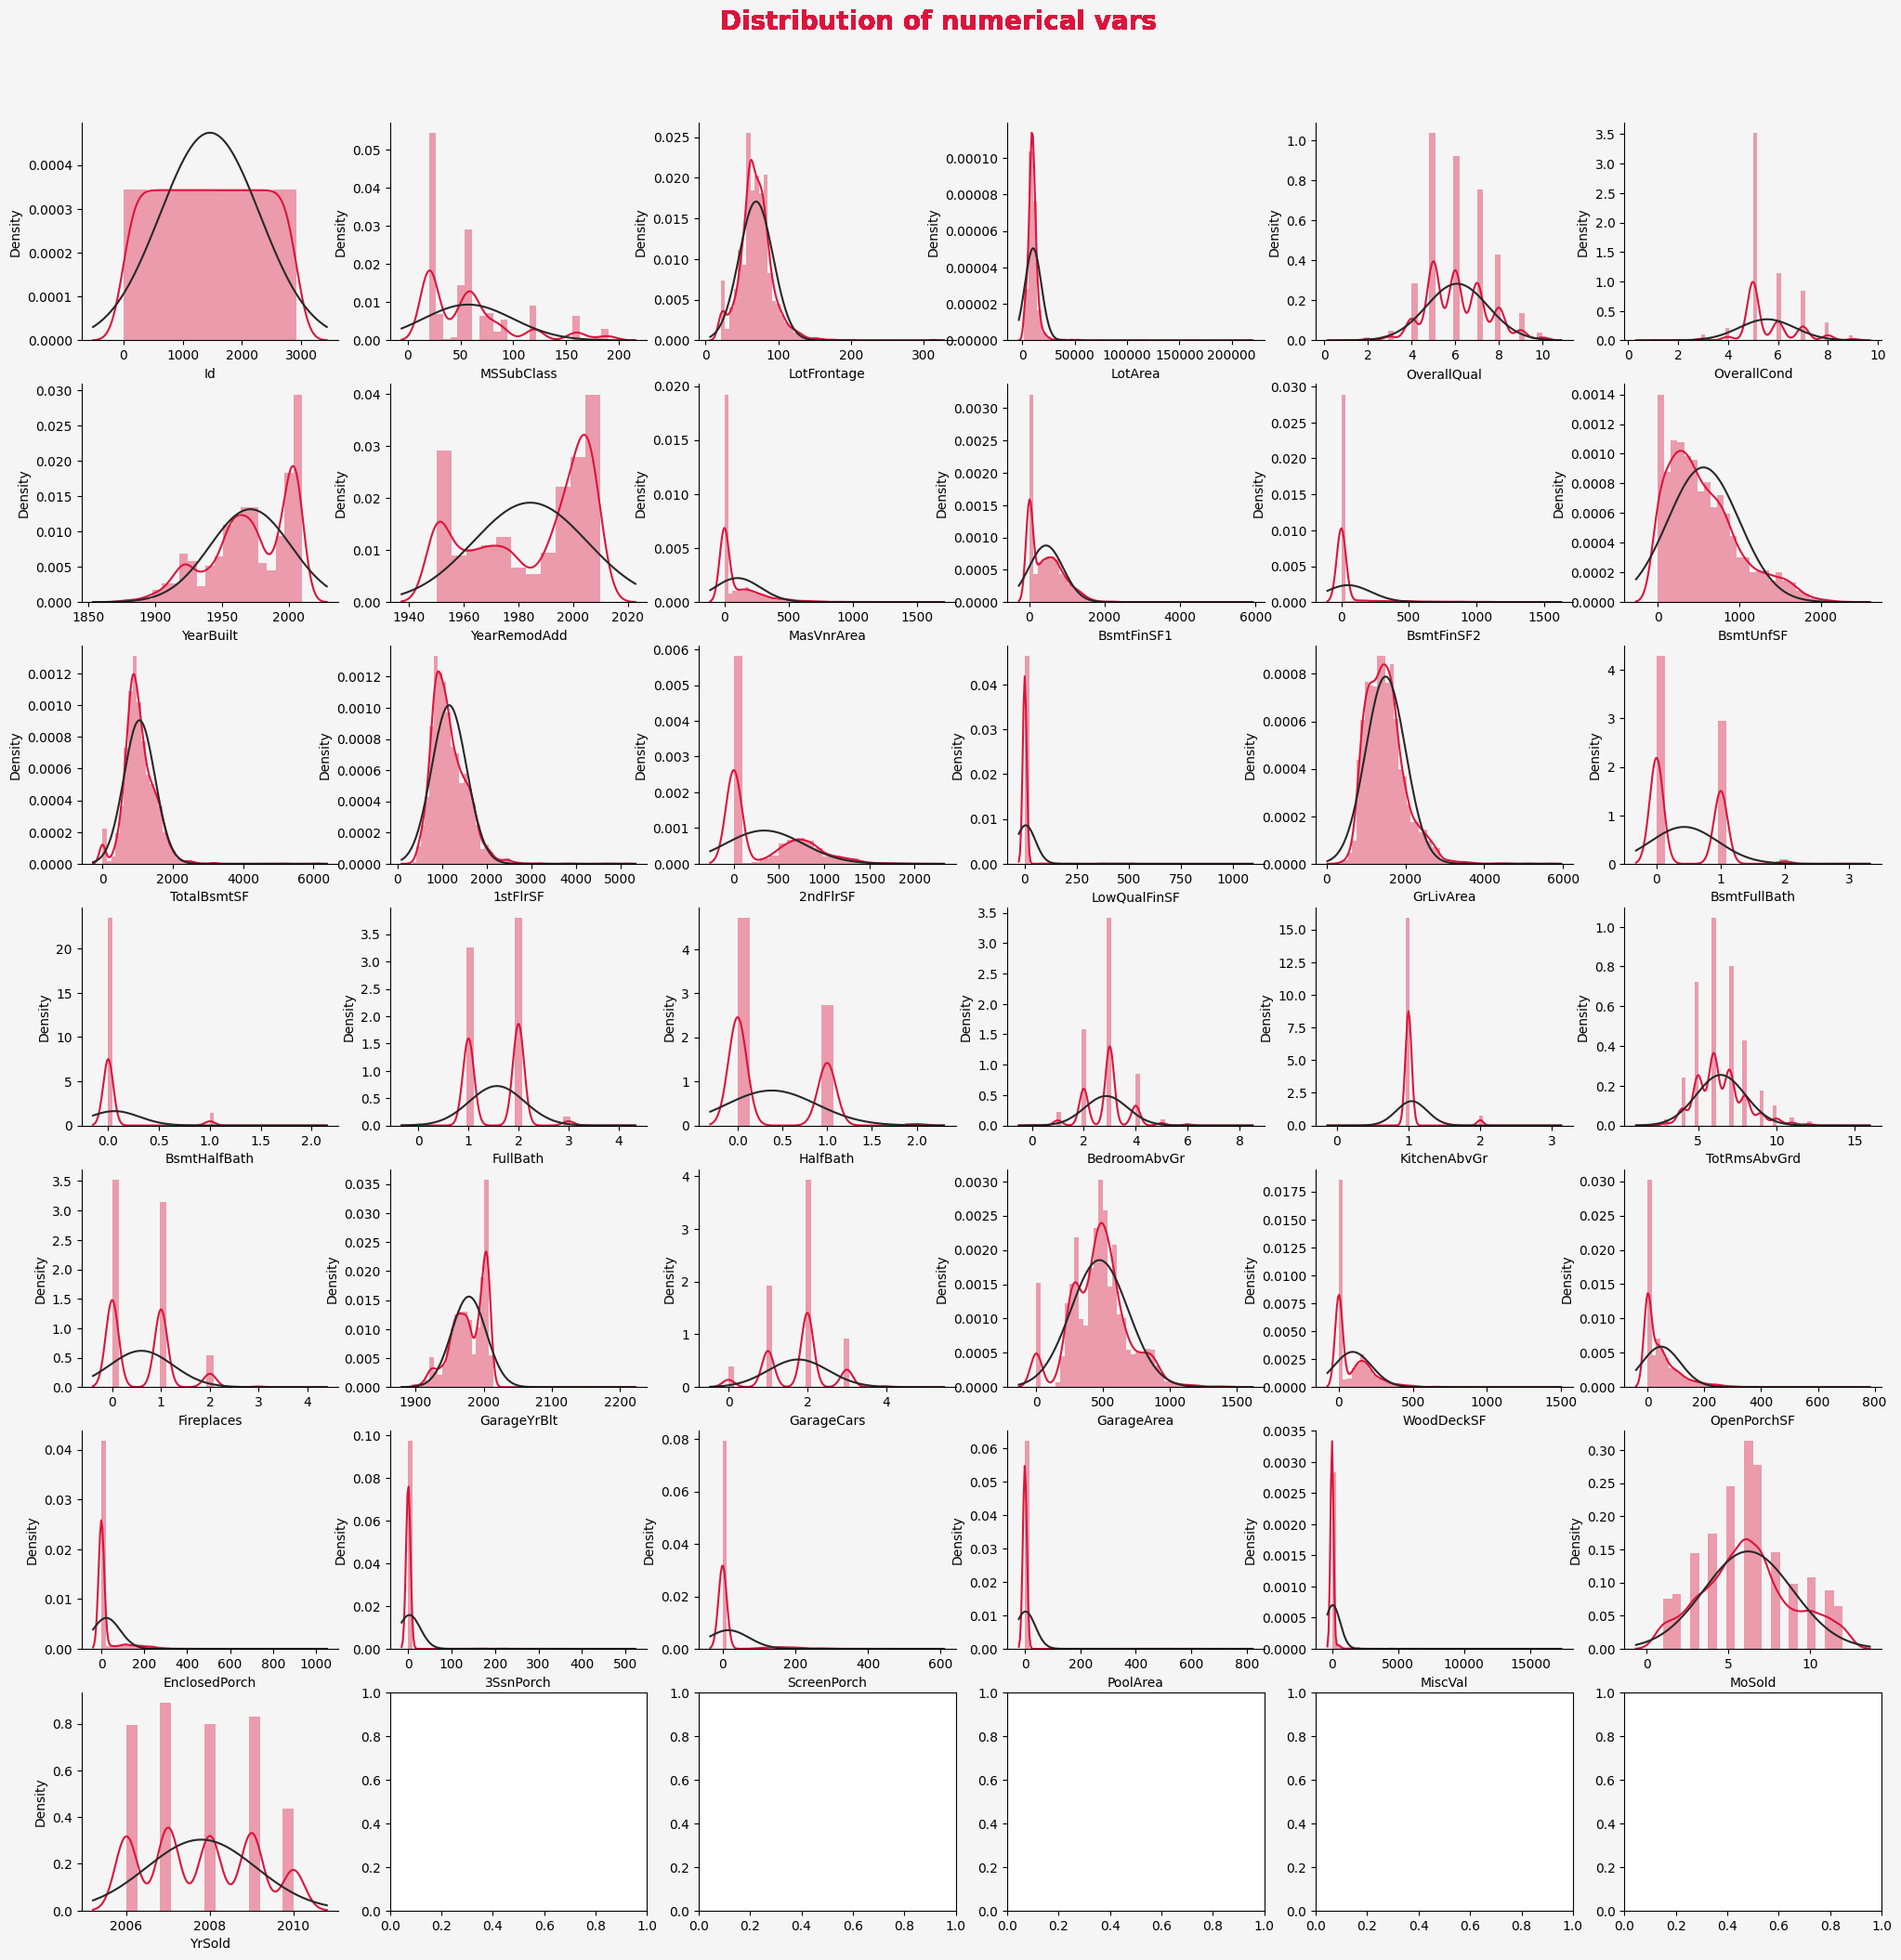

In [ ]:
f, ax = plt.subplots(7,6, figsize = (25, 25), facecolor = 'whitesmoke')
num_vars = all_data.columns[all_data.dtypes != 'object']
for i, c in enumerate(num_vars):
  g = sns.distplot(all_data[c], fit=norm, ax=ax[i//6, i%6], color='crimson')
  g.set_facecolor('whitesmoke')
  g.spines[['top', 'right']].set_visible(False)


  f.text(0.4, .92, 'Distribution of numerical vars', size=20, weight='bold', color='crimson')
plt.show()

일부 변수들은 로그 변환 또는 박스콕스(Box-Cox) 변환을 통해 정규분포를 따를 수 있을 것으로 보입니다.  
몇몇 변수에는 값이 0인 경우가 있어, 변환을 할 때는 +1을 더해주는 것이 필요해 보입니다.  
범주형 변수에 대해서는 막대그래프를 그려주십시오.  
일부 변수들은 특정 값(0)에 극단적으로 치우쳐 있었으며, 그로 인해 중요한 변수는 아닐 가능성이 있어 보입니다.  

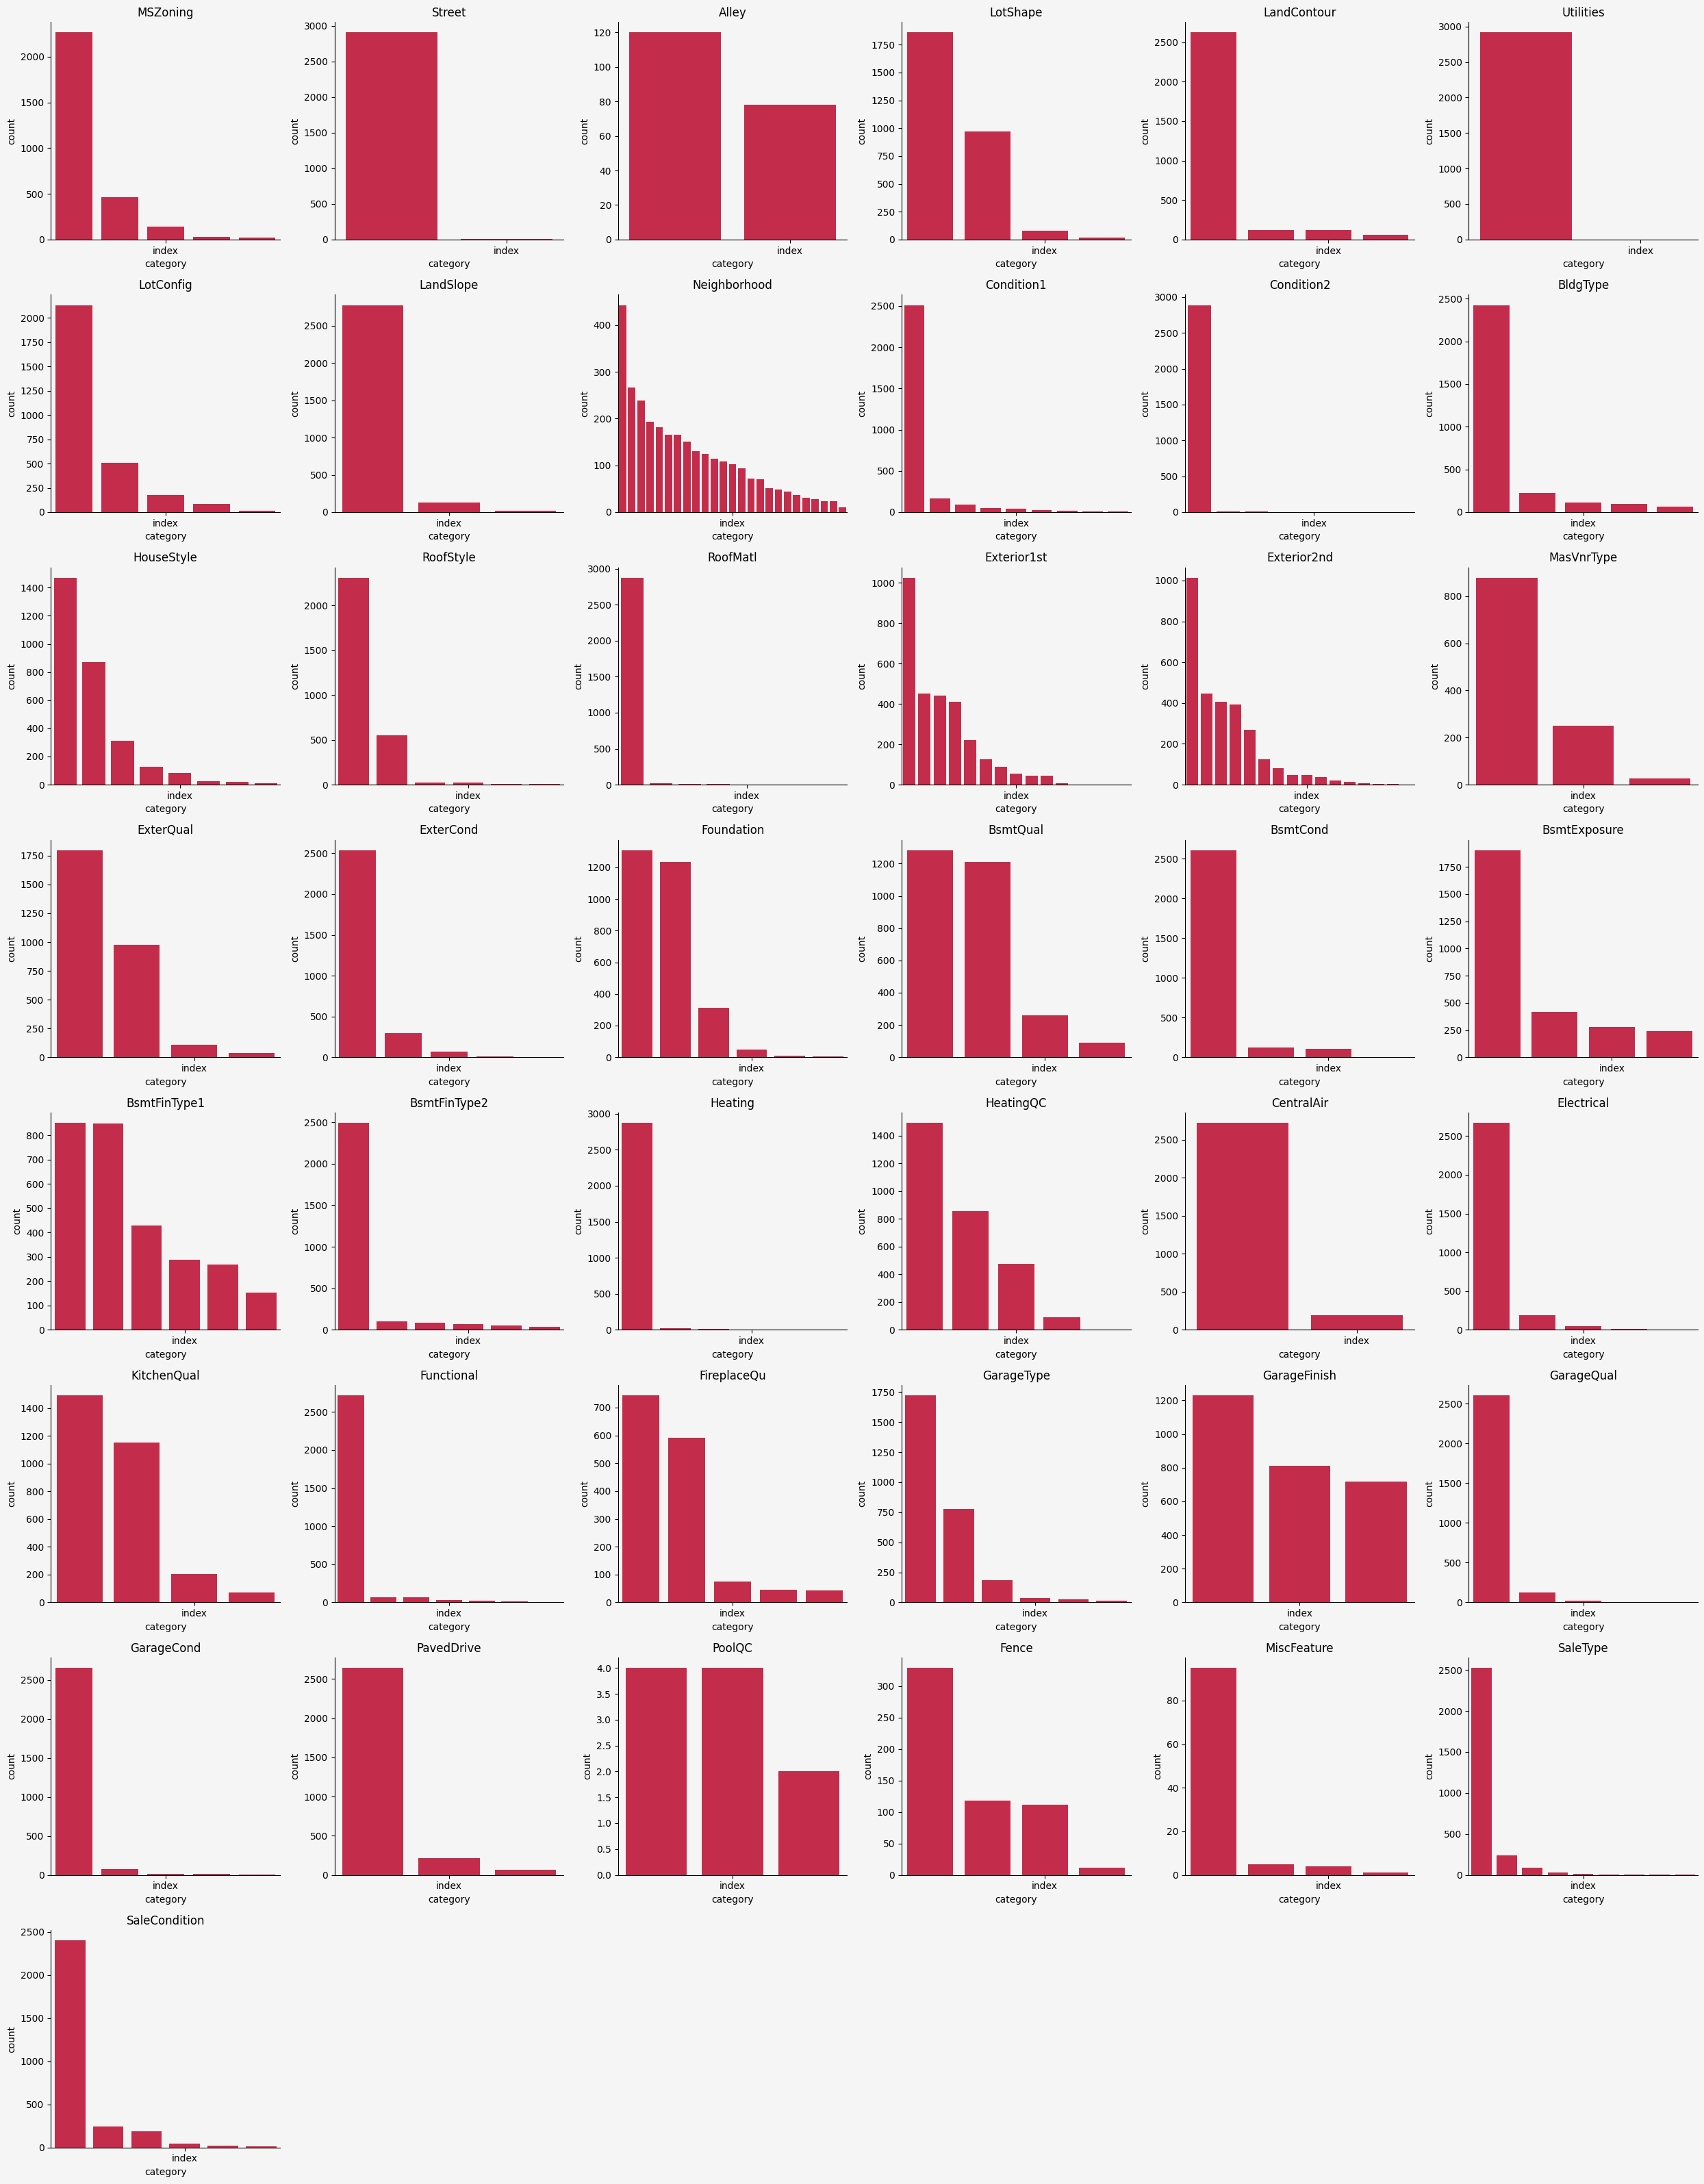

In [ ]:
# 범주형 시각화 코드가 오류가 나서 새로 짜달라고 했습니다

import math
import matplotlib.pyplot as plt
import seaborn as sns

cat_vars = all_data.columns[all_data.dtypes == 'object']
n = len(cat_vars)
n_cols = 6
n_rows = math.ceil(n / n_cols)

f, ax = plt.subplots(n_rows, n_cols, figsize=(25, 4 * n_rows), facecolor='whitesmoke')
ax = ax.flatten()

for i, c in enumerate(cat_vars):
    vc_df = all_data[c].value_counts().reset_index()
    vc_df.columns = ['category', 'count']

    g = sns.barplot(data=vc_df, x='category', y='count', ax=ax[i], color='crimson')
    g.set_title(c, fontsize=12)

    # 가운데 하나만 'index'로 표시
    mid = len(vc_df) // 2  # 가운데 위치 계산
    g.set_xticks([mid])  # 가운데 하나만 tick
    g.set_xticklabels(['index'])  # 해당 tick에 'index' 표시

    g.set_facecolor('whitesmoke')
    g.spines[['top', 'right']].set_visible(False)

# 남은 subplot 비우기
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()





# 5. 이변량 탐색 – 상관관계 분석, 히트맵, 중요한 변수 찾기
상관관계 분석은 두 변수 간의 상관관계를 파악하기 위한 기법입니다.
종속 변수와의 상관계수를 통해 비교적 강한 선형성을 가진 변수를 찾을 수 있으며,
이러한 변수들을 상대적으로 중요한 변수로 지정하고 등분산성을 테스트하였습니다.
또한, 독립 변수 간의 상관관계를 통해 변수들 간의 독립성도 점검하였습니다.

좋은 회귀 모델을 위한 몇 가지 가정
앞서 종속 변수와 잔차의 정규성을 확인하였으며, 이외에도 다음과 같은 가정들이 필요합니다.

선형성(Linearity):
독립 변수와 종속 변수 사이에는 선형적인 관계가 존재하는 것이 바람직합니다.
변수 변환이나 차원 확장(dimensional increase)을 통해 선형성을 갖도록 조정할 수 있습니다.

등분산성(Homogeneity):
잔차의 분산은 일정해야 합니다.
이를 확인하기 위해서는 독립 변수에 대한 잔차 도표를 그려보는 것이 좋습니다.
만약 점들이 기준선을 중심으로 무작위로 퍼져 있다면, 등분산성을 만족한다고 판단할 수 있습니다.

독립성(Independence):
독립 변수들 사이에는 상관관계가 없어야 합니다.
독립 변수 간의 높은 상관관계는 다중공선성(multicollinearity)을 유발하여 모델의 성능과 신뢰도를 저하시킬 수 있습니다.

비상관성(Irregularity):
잔차들 사이에도 상관관계가 존재해서는 안 됩니다.
이러한 비상관성을 검정하기 위해 Durbin-Watson 검정을 사용할 수 있습니다.

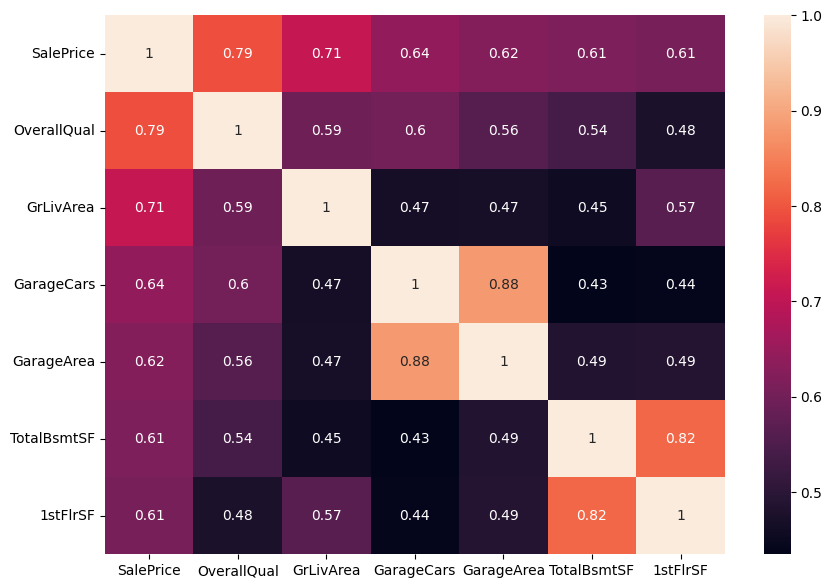

In [ ]:
f, ax = plt.subplots(figsize=(10,7))
numeric_train = train.select_dtypes(include=['number'])
highcorr_vars = (abs(numeric_train.corr().SalePrice).sort_values(ascending=False)[:7]).index
sns.heatmap(train[highcorr_vars].corr(),annot=True)
plt.show()

저는 종속 변수와의 상관관계가 가장 높은 상위 10개의 변수만 선택하여 다시 상관관계 분석을 수행하였습니다.
그 결과 **"OverallQual"**과 **"GrLiv Area"**가 가장 강한 상관관계를 가진 변수임을 확인하였습니다.
Garage Cars와 Garage Area 또한 높은 상관관계를 보였습니다.
그러나 독립 변수들 간에 상관관계가 높을 경우 다중공선성(multicollinearity) 을 유발하기 때문에 바람직하지 않습니다.

일부 테스트를 위해 다음과 같은 차트를 사용하였습니다:
산점도(Scatter), 박스플롯(Boxplot), 잔차 플롯(Residual Plot), 히스토그램(Histogram), QQ 플롯(Quantile-Quantile Plot).

In [ ]:
def hypo_test(x, y, cat=False):
    f, ax = plt.subplots(1, 4, figsize=(25, 5), facecolor='whitesmoke')
    if cat:
        sns.boxplot(x=train[x], y=train[y], ax=ax[0], color='crimson')
    else:
        sns.scatterplot(x=train[x], y=train[y], ax=ax[0], color='crimson')
        sns.regplot(x=train[x], y=train[y], ax=ax[0], color='crimson')
    sns.residplot(x=train[x], y=train[y], ax=ax[1], color='crimson')
    sns.distplot(train[x], fit=norm, ax=ax[2], color='crimson')
    probplot(train[x], plot=ax[3])
    ax[0].set_facecolor('whitesmoke')
    ax[1].set_facecolor('whitesmoke')
    ax[2].set_facecolor('whitesmoke')
    ax[3].set_facecolor('whitesmoke')
    ax[0].spines[['top', 'right']].set_visible(False)
    ax[1].spines[['top', 'right']].set_visible(False)
    ax[2].spines[['top', 'right']].set_visible(False)
    ax[3].spines[['top', 'right']].set_visible(False)

    f.suptitle(f'{x}', color='crimson', weight='bold', size=20)

    plt.show()

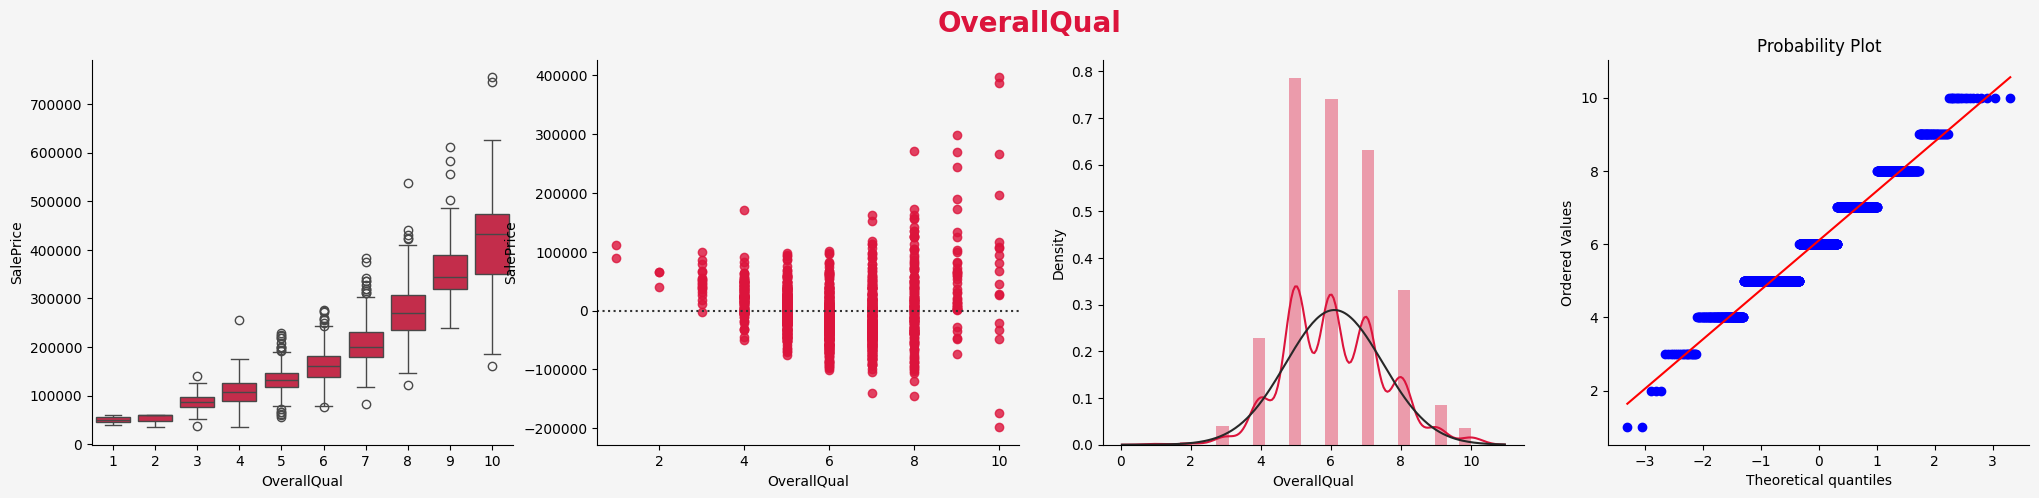

In [ ]:
hypo_test('OverallQual', 'SalePrice', True)

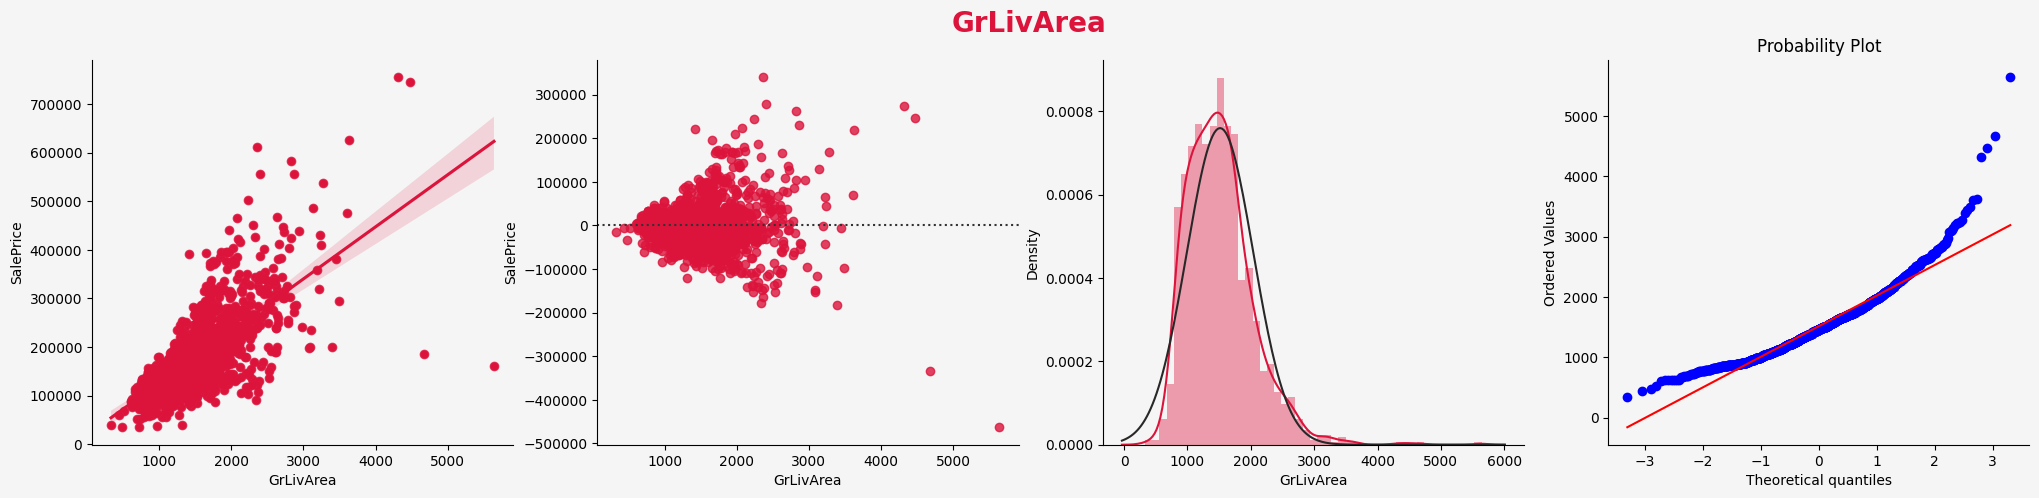

In [ ]:
hypo_test('GrLivArea', 'SalePrice')

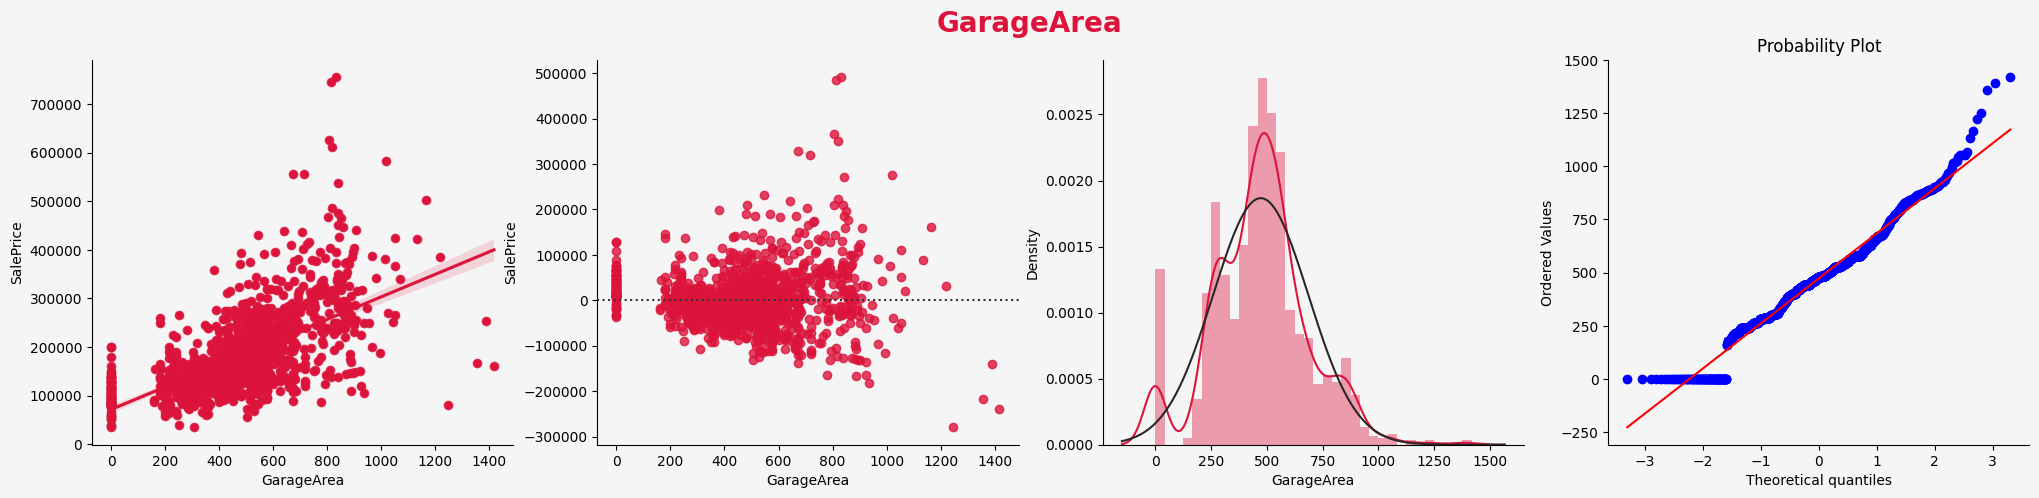

In [ ]:
hypo_test('GarageArea', 'SalePrice')

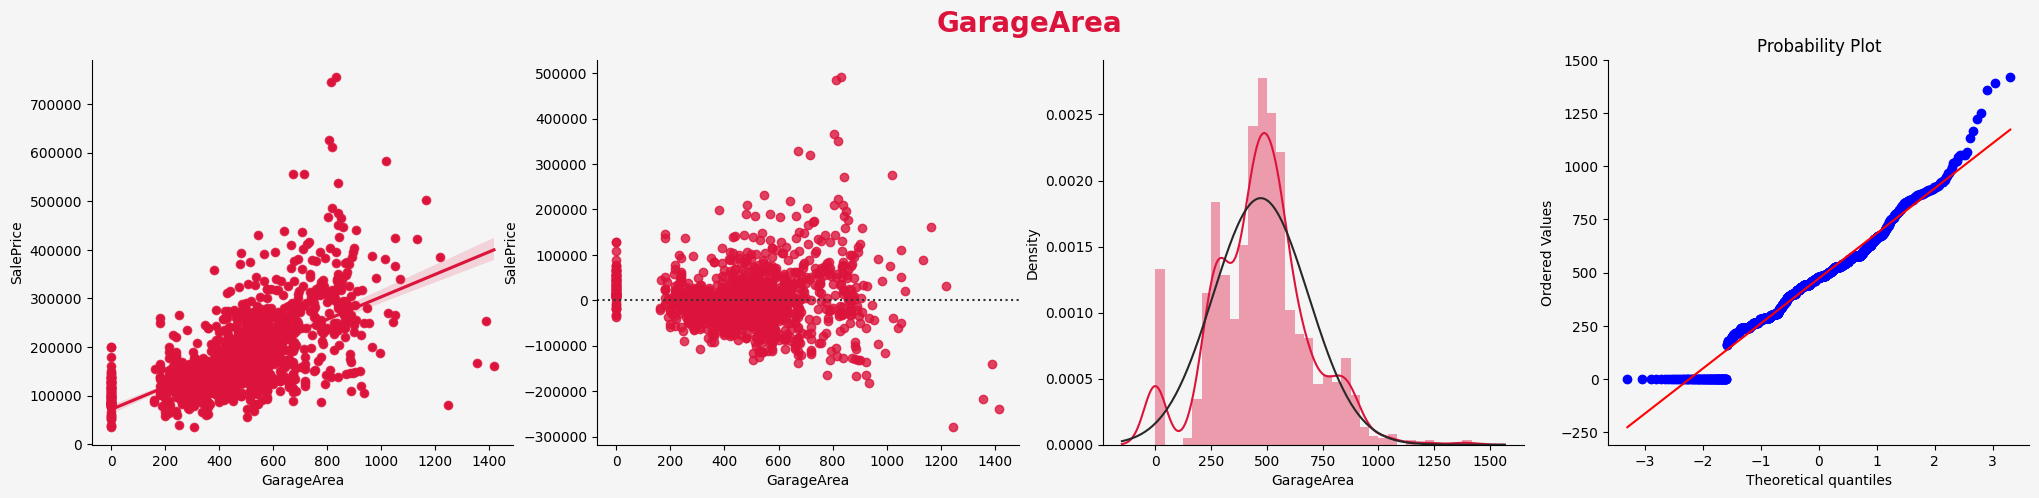

In [ ]:
hypo_test('GarageArea', 'SalePrice')

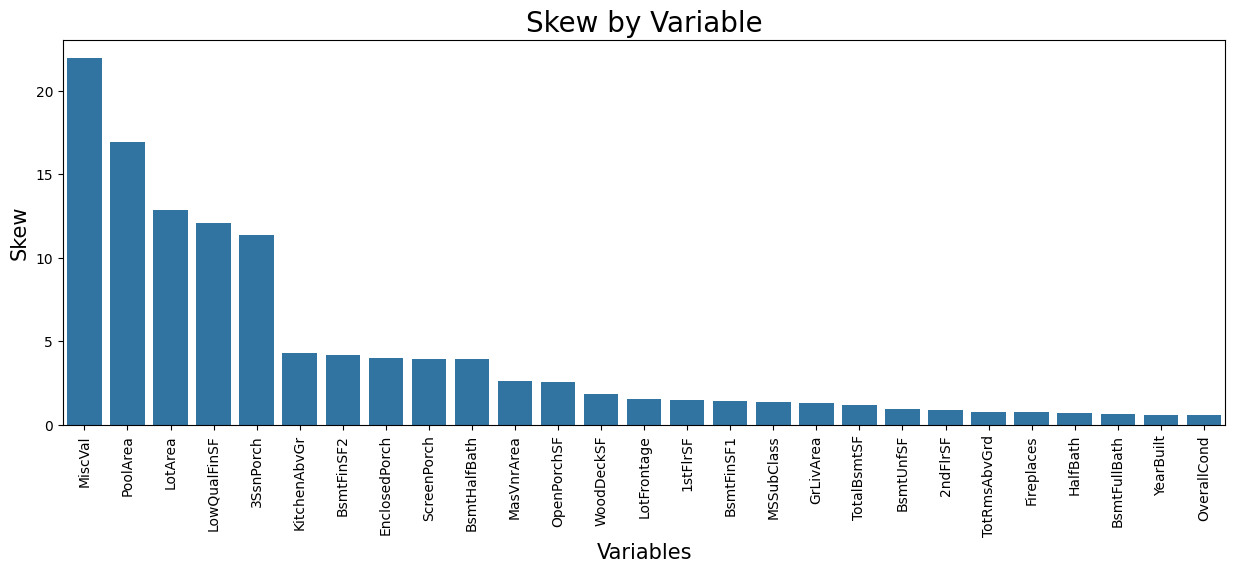

In [ ]:
numeric_data = all_data.select_dtypes(include='number')

skews = abs(numeric_data.skew()).sort_values(ascending=False)
kurts = abs(numeric_data.kurt()).sort_values(ascending=False)
skew_kurt_table = pd.DataFrame([skews, kurts], index=['skew', 'kurt']).T

ntv = skew_kurt_table[skew_kurt_table['skew'] > 0.5].index

plt.figure(figsize=(15,5))
sns.barplot(x=ntv, y=skew_kurt_table.loc[ntv]['skew'])
plt.xticks(rotation=90)
plt.title('Skew by Variable', size=20)
plt.xlabel('Variables', size=15)
plt.ylabel('Skew', size=15)
plt.show()


##  결론 (Conclusion)
각 변수와 SalePrice 간의 상관관계를 분석한 결과, OverallQual, GrLivArea, CarArea 등의 변수들이 높은 선형성을 가지고 있음을 확인했습니다.
이러한 선형성은 박스플롯과 산점도를 통해 시각화하였습니다.

이 변수들이 중요한 변수라고 판단되어, 등분산성을 확인하기 위해 잔차도를 그리고, 정규성을 확인하기 위해 히스토그램과 Q-Q 플롯도 작성하였습니다.

각 변수의 잔차 점들이 무작위로 분포되지 않고 특정한 패턴이나 형태를 가지는 것으로 보아 등분산성 조건을 만족하지 않음을 확인할 수 있었습니다.
또한, 히스토그램과 Q-Q 플롯의 결과를 통해 정규성 역시 이상적이지 않음을 확인했습니다.
이러한 문제들은 로그 변환 또는 Box-Cox 변환 등을 통해 해결할 수 있을 것으로 보입니다.

또한 일부 독립 변수들 간에도 상관관계가 존재함을 확인했으며, 예상대로 산점도를 통해 시각화하였습니다.
독립 변수 간의 높은 상관관계는 다중공선성(Multicollinearity) 을 유발할 수 있으며, 이는 모델의 설명력을 떨어뜨릴 수 있습니다.

따라서 변수 선택이나 차원 축소를 바로 적용하기보다는, 정규화(Regularization) 기법을 먼저 적용해보기로 결정했습니다.
선형 모델의 경우, 릿지(Ridge)나 라쏘(Lasso) 와 같은 정규화 기법을 통해 이 문제를 완화할 수 있습니다.

모든 변수를 시각화하기엔 어려움이 있었기 때문에, 왜도(skewness) 와 첨도(kurtosis) 를 활용하여 변환이 필요한 독립 변수들을 선별해 분석했습니다.

## 📘 등분산성과 잔차의 관계

### ✅ 등분산성(Homoscedasticity)이란?
- 회귀 분석의 가정 중 하나임  
- 잔차(오차)의 분산이 독립 변수나 예측값의 크기와 무관하게 **일정함**을 의미함  
- 쉽게 말해, 예측값이 크든 작든 잔차의 분포가 고르게 퍼져 있어야 함

### ✅ 잔차(residual)란?
- 실제 관측값과 예측값의 차이  
- 수식: 잔차 = 실제값 - 예측값  
- 모델의 예측 정확도 및 문제점을 파악하는 데 사용함

### ✅ 등분산성과 잔차의 관계
- 잔차가 예측값이나 독립 변수에 따라 커지거나 작아지면 **이분산성(heteroscedasticity)** 상태임  
- 이분산성일 경우, 잔차 vs 예측값 그래프에서 **패턴**이나 **모양(나팔형, 부채형 등)** 나타남  
- 등분산성일 경우, 잔차가 랜덤하게 흩어져 있음

### ✅ 등분산성 위반 시 문제점
- 회귀 계수 자체는 추정 가능하나, **표준 오차와 p-value가 부정확**해짐  
- 추론의 신뢰성이 떨어짐 → 잘못된 의사결정 가능

### ✅ 등분산성 확인 방법
1. 잔차 vs 예측값 산점도 → 랜덤 분포 여부 확인  
2. Breusch-Pagan test, White test 등 통계적 검정

### ✅ 등분산성 위반 시 해결 방법
- 종속변수에 로그(log) 변환 또는 Box-Cox 변환 적용  
- 가중 회귀(Weighted Least Squares) 사용  
- 모델에 정규화(regularization) 적용도 고려 가능

### ✅ 요약
- 등분산성은 선형 회귀 모델의 핵심 가정 중 하나임  
- 잔차 분석을 통해 등분산 여부를 반드시 시각화하거나 검정해야 함  
- 위반 시 적절한 전처리 또는 모델 변경 필요


# 피쳐 엔지니어링
1. 아이디 삭제

In [ ]:
train_id = train.Id
test_id = test.Id
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

#2. 데이터 정제 – 이상치(Outlier)
이상치가 포함된 데이터셋은 모델의 성능을 저하시킬 수 있습니다.
학습 데이터에 존재하는 이상치를 제거하는 것은 선택 사항이지만, 종속 변수와 강한 상관관계를 보이는 변수의 산점도에서 두 개의 이상치를 발견했습니다.
이 두 점은 직선 경향에서 많이 벗어난 위치에 있었습니다.

이상치 탐색 방법에는 단변량 통계 기반과 시각적 접근이 있습니다.
먼저, 단변량 기준으로는 정규분포, 우도 함수, IQR(사분위 범위) 등을 활용해 임계값을 벗어난 값을 이상치로 간주할 수 있습니다.
하지만 임계값을 벗어났다고 해서 항상 이상치라고 단정할 수는 없습니다.
예를 들어, GrLivArea 변수의 산점도에서는 우측 상단에 두 개의 점이 멀리 떨어져 있는데,
이들은 다른 관측치와 값 차이는 크지만 오히려 선형성을 증명하는 데 중요한 역할을 할 수 있으므로 신중한 판단이 필요합니다.

또한 두 변수 간에 선형 관계 등 뚜렷한 패턴이 있는 경우, 산점도를 통해 이상치를 직관적으로 파악할 수 있습니다.
앞서 종속 변수와 강한 상관관계를 보이는 변수들을 시각화하면서 GrLivArea에서 두 개의 이상치를 발견했습니다.

이외에도 클러스터링 기반의 DBSCAN 알고리즘을 활용하여 이상치를 탐지할 수 있습니다.
DBSCAN은 반경(epsilon)과 최소 이웃 수(min_samples)를 기준으로 밀도 기반 클러스터를 형성합니다.
핵심점 주변에 충분한 이웃이 없는 점은 클러스터에 포함되지 않으며, 이들을 이상치로 간주합니다.
이에 따라 GrLivArea와 SalePrice에 스케일링을 적용한 후 DBSCAN 알고리즘을 사용하여 이상치를 탐지해보았습니다.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

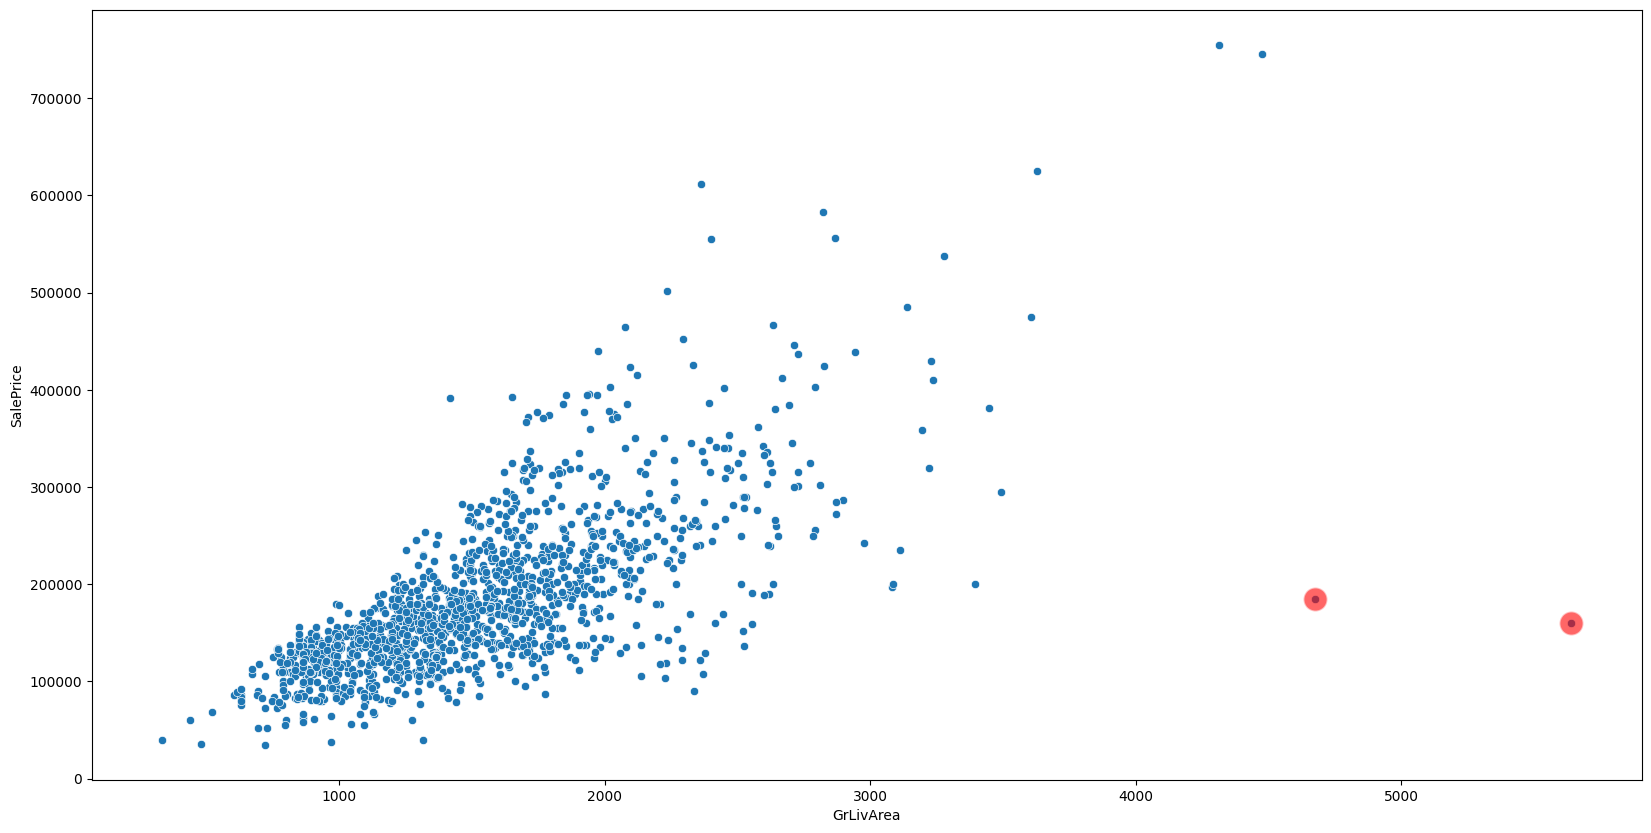

In [ ]:
plt.subplots(figsize=(20,10))
outlier_idx = train.GrLivArea.sort_values(ascending=False)[:2].index # GrLivArea(거주 면적)가 큰 순서대로 정렬한 후, 상위 2개 인덱스를 추출해 이상치 인덱스로 저장함
sns.scatterplot(x=train['GrLivArea'], y=train.SalePrice)
sns.scatterplot(x=train.iloc[outlier_idx]['GrLivArea'], y=train.iloc[outlier_idx].SalePrice, color = 'r', s=300, alpha=.6) # # 이상치로 판단한 상위 2개 관측치를 빨간색(r)으로 강조하여 같은 산점도 위에 추가로 표시함 점 크기는 s=300으로 키우고, 투명도는 alpha=0.6으로 설정


### ✅ 왜 두 개의 산점도가 하나의 그래프에 그려질까?

`sns.scatterplot()`을 두 번 호출했지만, `ax` 인자를 명시하지 않았기 때문에 두 그래프는 모두 **현재 활성화된 동일한 축(Axes)** 위에 자동으로 그려짐.  
`plt.subplots()`로 figure만 생성하고 `ax`를 저장하지 않았기 때문에, seaborn은 내부적으로 **공용 Axes 객체를 사용**함.  
따라서 두 산점도는 **하나의 그래프 위에 겹쳐져 시각화**됨.


In [ ]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(train[['GrLivArea', 'SalePrice']]), columns=['GrLivArea', 'SalePrice'] )# GrLivArea와 SalePrice를 선택하여 StandardScaler로 표준화(평균 0, 표준편차 1)한 뒤, DataFrame으로 변환
dbscan_model = DBSCAN(eps = 1.5, min_samples=3).fit(scaled_data) # DBSCAN 알고리즘을 사용해 클러스터링 수행. 반경(eps)=1.5, 최소 이웃 수(min_samples)=3으로 설정
# 표준화된 데이터를 기반으로 밀도 기반 클러스터링 수행
tmp = pd.concat((scaled_data, pd.DataFrame(dbscan_model.labels_, columns=['label'])), axis=1) # 클러스터링 결과 라벨(dbscan_model.labels_)을 scaled_data와 열 방향으로 결합하여 새로운 DataFrame 생성
# label 컬럼이 클러스터 번호를 나타냄. -1은 이상치(outlier)를 의미함

### 📌 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**DBSCAN**은 밀도 기반의 클러스터링 알고리즘으로, 데이터가 조밀하게 분포된 영역을 클러스터로 정의하고, 밀도가 낮은 지점은 **이상치(노이즈)** 로 간주

---

#### ✅ 주요 개념

- **Core Point(핵심점)**: 주어진 반경(epsilon) 내에 `min_samples` 이상의 이웃이 존재하는 점  
- **Border Point(경계점)**: 이웃 수는 부족하지만, 핵심점의 반경 안에 포함된 점  
- **Noise(노이즈)**: 어떤 핵심점의 반경 안에도 속하지 않으며, 이웃도 부족한 점 → **이상치**로 간주됨

---

#### ✅ 주요 하이퍼파라미터
- `eps`: 클러스터로 묶을 최대 거리 (반경)
- `min_samples`: 핵심점으로 간주되기 위한 최소 이웃 수

---

#### ✅ 장점
- 클러스터의 개수를 사전에 지정할 필요 없음
- 다양한 형태와 크기의 클러스터 탐지가 가능
- 이상치(outlier) 자동 탐지 기능 내장

---

#### ❗ 단점
- eps와 min_samples에 따라 결과가 크게 달라짐
- 고차원 데이터에서는 거리 기반 판단이 부정확할 수 있음

---

#### ✅ 사용 예시
```python
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(df[['x1', 'x2']])
model = DBSCAN(eps=1.0, min_samples=5).fit(data)
labels = model.labels_
```

- `labels` 값이 -1이면 이상치, 0 이상의 숫자는 각각의 클러스터

---

DBSCAN은 이상치 탐지와 밀도 기반 클러스터링을 동시에 수행할 수 있어, 데이터 정제 및 군집 분석에서 유용함.

In [ ]:
tmp.label.value_counts()

,count
label,
0,1456
-1,4


In [ ]:
tmp

,GrLivArea,SalePrice,label
0,0.370333,0.347273,0
1,-0.482512,0.007288,0
2,0.515013,0.536154,0
3,0.383659,-0.515281,0
4,1.299326,0.869843,0
...,...,...,...
1455,0.250402,-0.074560,0
1456,1.061367,0.366161,0
1457,1.569647,1.077611,0
1458,-0.832788,-0.488523,0


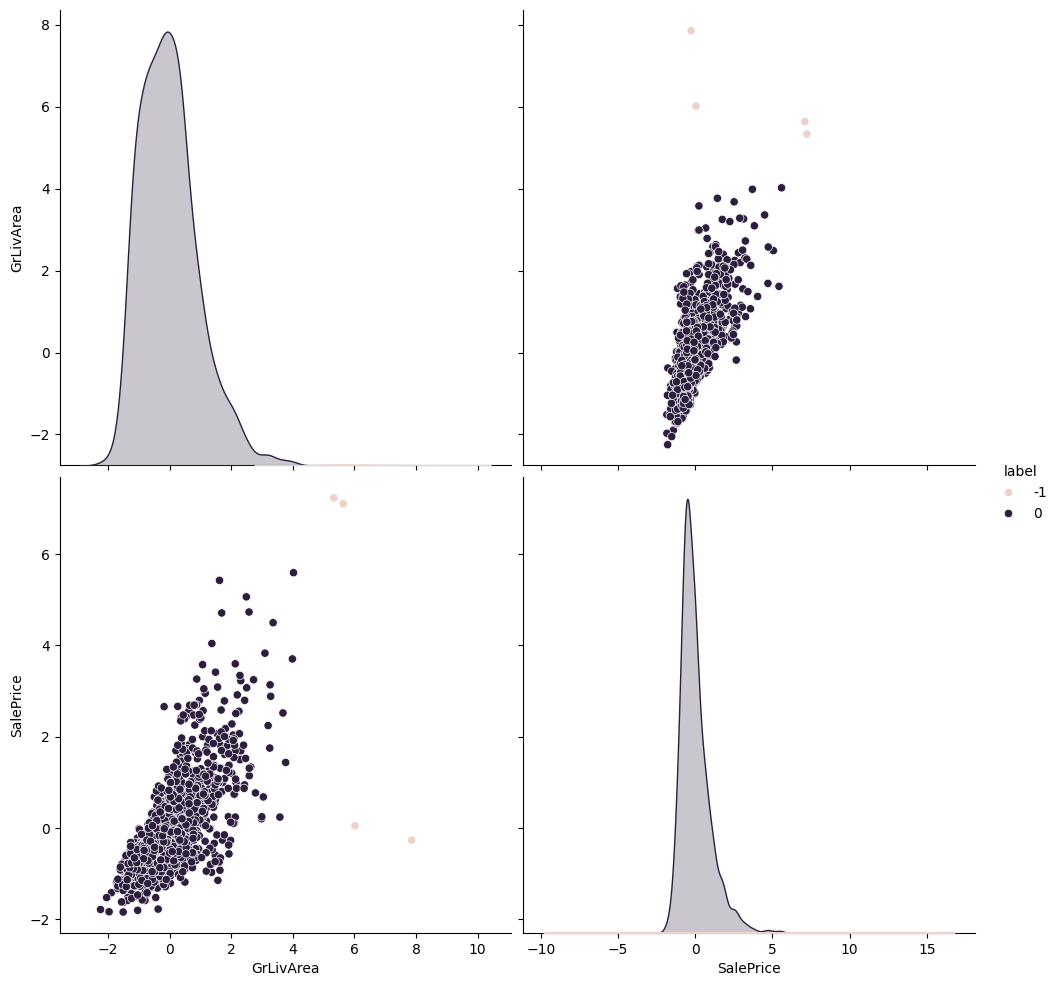

In [ ]:
sns.pairplot(tmp, hue='label', size=5)
plt.show()

In [ ]:
train.drop(train.GrLivArea.sort_values(ascending=False)[:2].index, axis=0, inplace=True)

결론:
산점도를 통해 2개의 이상치를 발견하였고, 해당 2개 관측치를 제거하였습니다.  
DBSCAN을 활용한 경우에는 총 4개의 관측치가 이상치로 판단되었습니다.

### 3. 학습 데이터와 테스트 데이터 병합, 종속 변수 분리
개요:
학습 데이터에서 이상치를 제거한 후, 이제 테스트 데이터와 병합함.  
이후, 종속 변수(SalePrice)는 따로 분리하여 모델 학습에 사용할 준비를 함.

In [ ]:
train_size = train.shape[0]
y_train = train.SalePrice.values # SalePrice 컬럼(종속 변수)을 추출하여 y_train에 저장함, .values를 사용해 넘파이 배열 형태로 저장하여 모델 학습에 바로 사용 가능하게 함.
all_data = pd.concat((train, test), axis = 0).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
train.shape, test.shape, all_data.shape, y_train.shape

((1458, 80), (1459, 79), (2917, 79), (1458,))

✅ drop=True란?
기본적으로 .reset_index()는 기존 인덱스를 새로운 컬럼으로 남겨둠
예: index라는 새 컬럼이 생김

하지만 drop=True를 쓰면: → 기존 인덱스를 완전히 제거하고,
→ 새로운 0부터 시작하는 인덱스로 초기화함

## 4. 데이터 정제 – 결측치 처리
결측치는 반드시 처리해야 하는 요소이며, 각 독립 변수의 특성과 의미를 바탕으로 적절하게 다루는 것이 중요합니다.
결측치를 처리하는 방법에는 여러 가지가 있으며, 상황에 따라 선택적으로 적용할 수 있습니다.

**삭제(Delete)**는 가장 간단하고 강력한 방법으로, 결측치가 포함된 행이나 열을 제거하는 방식입니다.
하지만 테스트 데이터에도 결측치가 존재할 수 있기 때문에 행을 삭제하는 것은 신중해야 하며,
열을 제거할 경우 중요한 변수를 잃을 수 있기 때문에 가능하다면 삭제는 피하는 것이 좋습니다.

**특정 값**으로 대체하는 방법은 변수에 대한 도메인 지식이 있을 때 시도할 수 있습니다.
예를 들어, 결측 자체가 ‘없음’이나 부정적인 의미를 가지는 변수라면, 해당 결측값을 특정한 값으로 해석하여 대체할 수 있습니다.

**중심 경향 값**(평균, 중앙값, 최솟값 등)으로 대체하는 방법도 있습니다.
연속형 변수는 보통 중앙값으로, 범주형 변수는 최빈값이나 최솟값으로 대체합니다.
그 외에도 단순 확률 기반 대체나 다중 대체(MICE) 같은 통계적 방법도 있습니다.

이번 분석에서는 각 변수의 설명을 참고하여 다음과 같이 처리하였습니다.
연속형 변수는 관련 있는 범주형 변수와 함께 그룹을 나눈 뒤, 그룹별 중앙값으로 대체하거나,
결측 자체가 의미를 가질 경우에는 0으로 대체하였습니다.
범주형 변수는 value_counts()를 통해 분포를 확인한 뒤,
NA나 POOL처럼 결측이 부정적인 의미일 경우에는 ‘None’으로 대체하였고,
그 외에는 관련 변수 기준으로 그룹별 분포를 살펴보고 가장 낮은 등급의 값으로 대체하였습니다.

## 📊 결측치 처리: 확률 기반 대체와 다중 대체(MICE)

---

### ✅ 1. 단순 확률 기반 대체 (Simple Probabilistic Imputation)

- **개념**: 결측값을 해당 변수의 기존 값 분포에 따라 **무작위로 샘플링하여 대체**하는 방식
- 예를 들어, 한 범주형 변수의 값이 A:50%, B:30%, C:20%로 분포되어 있다면,  
  결측값에 대해 이 확률대로 **임의로 A, B, C 중 하나를 선택하여 채움**
- **장점**: 원래의 데이터 분포를 유지할 수 있음
- **단점**: 무작위성이 있어 결과가 매번 달라질 수 있음

---

### ✅ 2. 다중 대체 (MICE: Multiple Imputation by Chained Equations)

- **개념**: 다른 변수들과의 관계를 이용해 결측값을 예측하고 채우는 **고급 통계적 방법**
- 여러 번 반복(iteration)을 통해, 결측값을 **다양한 예측 모델로 여러 번 대체**한 뒤 평균을 사용
- 각 변수의 결측치를 순차적으로 모델링하며 채우기 때문에 **‘Chained Equation(연쇄 방정식)’**이라고 부름

#### 💡 처리 과정
1. 결측값이 있는 변수 하나를 선택
2. 다른 변수들을 사용해 해당 변수의 결측치를 예측 (예: 선형 회귀, 로지스틱 회귀 등)
3. 예측값을 기반으로 결측치를 대체
4. 다음 변수에 대해 반복 수행
5. 이 과정을 여러 번 반복하여 안정적인 예측값 도출

#### 📈 장점
- 변수 간의 관계를 고려하여 결측치를 채우므로 **정확도가 높음**
- 결측이 많은 경우에도 유용

#### ⚠️ 단점
- 계산량이 많고 처리 시간이 오래 걸릴 수 있음
- 통계적 지식과 도구 사용 능력이 필요함

---

### 🛠️ 파이썬에서 사용 예시 (MICE)

```python
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
imputed_data = imputer.fit_transform(data_with_nan)
```

---

### ✅ 요약

| 방법                     | 설명                                | 장점                             | 단점                     |
|--------------------------|-------------------------------------|----------------------------------|--------------------------|
| 단순 확률 기반 대체      | 기존 분포 비율대로 무작위 채움     | 분포 유지, 간단함               | 무작위성, 결과 불안정    |
| 다중 대체 (MICE)         | 다른 변수들로 예측해 여러 번 채움 | 변수 간 관계 고려, 정확도 높음  | 복잡함, 계산 비용 큼     |

---

두 방법 모두 데이터의 특성과 분석 목적에 따라 선택적으로 활용할 수 있습니다.

In [ ]:
all_data.columns[all_data.isnull().sum() > 0]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

예시 1) LotFrontage 변수는 Neighborhood(이웃/지역) 별로 중앙값으로 대체하였습니다.

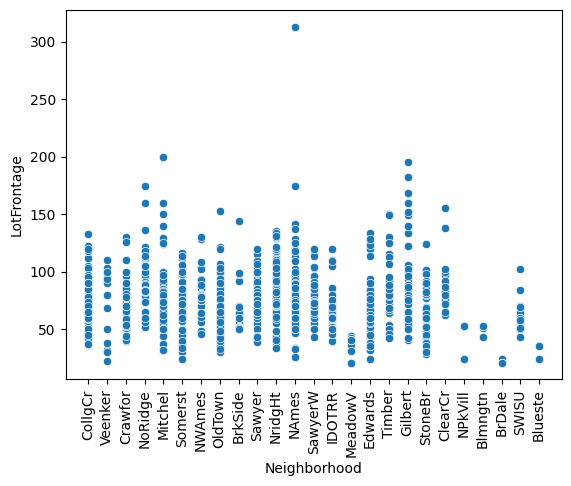

In [ ]:
sns.scatterplot(x=all_data.Neighborhood, y=all_data.LotFrontage)
plt.xticks(rotation=90)
plt.show()

예시 2) Alley는 NA 값을 가질 수 있는 순위형 변수이며,
이러한 값들이 결측치로 처리되어 있었기 때문에 ‘None’으로 대체하였습니다.

In [ ]:
all_data.Alley.value_counts()

,count
Alley,
Grvl,120
Pave,78


예시 3) Utilities 변수는 대부분의 값이 AllPub으로 극단적으로 치우쳐 있으므로,
해당 변수를 가장 낮은 값으로 대체하였습니다.

In [ ]:
all_data.Utilities.value_counts()

,count
Utilities,
AllPub,2914
NoSeWa,1


예시 4) GarageArea는 차고(Garage)가 없는 경우 결측치로 나타나므로,
해당 결측값은 0으로 대체하였습니다.

In [ ]:
all_data.GarageArea.value_counts()

,count
GarageArea,
0.0,157
576.0,97
440.0,96
240.0,69
484.0,68
...,...
217.0,1
323.0,1
265.0,1


In [ ]:
for c in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC",
          'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    all_data[c] = all_data[c].fillna('None')

for c in ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1',
          'BsmtFinSF2','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
          'BsmtUnfSF','TotalBsmtSF']:
    all_data[c] = all_data[c].fillna(0)

for c in ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [ ]:
all_data.isnull().sum().sum() # 즉, 전체 데이터프레임에서의 결측치 총합

np.int64(0)

## 5. 수치형 변수 변환 – LabelEncoder, Box-Cox, 로그 변환
연속형 변수의 정규성과 등분산성을 확보하기 위해 로그 변환과 Box-Cox 변환을 적용하였습니다.
순서(우선순위)가 있는 범주형 변수에는 Label Encoding을 적용하였고,
순서가 없는 동등한 범주형 변수에는 One-Hot Encoding을 사용하였습니다.
또한, 종속 변수의 정규성을 확보하기 위해 로그 변환을 적용하였습니다.

In [ ]:
train[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']] =\
train[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']].astype('str')

test[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']] =\
test[['MSSubClass', 'GarageYrBlt', 'MoSold', 'OverallCond', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']].astype('str')

order_vars = [
    'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageYrBlt', 'GarageQual',
    'GarageCond', 'PoolQC', 'MoSold', 'YrSold'
]

# 숫자처럼 보여도 실제 의미가 범주형이면, 문자형으로 바꿔서 적절한 인코딩 처리

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# numeric_feats에 포함된 수치형 변수들에 대해 다음을 수행:
# 1. 각 변수에서 결측치를 제거 (x.dropna())
# 2. 왜도(skewness)를 계산 (scipy.stats.skew 함수 사용)
# 3. 계산된 왜도를 기준으로 내림차순 정렬 (왜곡이 큰 변수부터 순서대로 정렬)
# 결과적으로, 왜도 값이 큰 변수들만을 skewed_feats에 저장함
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness = skewness[abs(skewness.Skew) > 0.5]
skewness

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


The algorithm terminated without finding a valid bracket. Consider trying different initial points.  

 boxcox_normmax(all_data[feat] + 1)에서 적절한 λ(lambda) 값을 찾는 과정에서 실패했다는 오류발생   
   
 ✅ 방법 1: boxcox_normmax 없이 고정 λ 사용

In [ ]:
from scipy.special import boxcox1p

skewed_features = skewness[abs(skewness) > 0.5].index
lam = 0.15

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat] + 1, lam)


In [ ]:
numeric_feat = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness = skewness[abs(skewness.Skew) > 0.5]
skewness

,Skew
PoolArea,15.797176
3SsnPorch,8.959130
LowQualFinSF,8.800440
MiscVal,5.671907
KitchenAbvGr,3.965545
BsmtHalfBath,3.822149
ScreenPorch,2.989540
BsmtFinSF2,2.593633
EnclosedPorch,2.051789
MasVnrArea,0.671296


# 📦 Box-Cox 변환 정리

## 개념
Box-Cox 변환은 비정규분포 데이터를 정규분포에 가깝게 만드는 통계적 기법임.  
로그, 제곱근, 역수 변환을 일반화한 형태로 왜도(skewness)를 줄이는 데 사용함.  
회귀 분석 등 정규성을 가정하는 모델에서 성능 향상 기대 가능함.

## 수식

Box-Cox 변환은 다음과 같은 형태로 정의됨:

$$
y(\lambda) =
\begin{cases}
\frac{x^\lambda - 1}{\lambda}, & \text{if } \lambda \ne 0 \\\\
\ln(x), & \text{if } \lambda = 0
\end{cases}
$$

x는 양수여야 하며, λ(lambda)는 변환 강도를 조절하는 하이퍼파라미터임.

## 왜 사용하는가
왜도가 크면 데이터가 한쪽으로 치우쳐 있어 모델이 제대로 학습하지 못함.  
특히 선형 회귀 계열 모델은 입력 데이터의 정규성을 가정함.  
Box-Cox 변환은 분포를 더 대칭적으로 만들어 예측 성능 향상에 도움을 줌.

## Python 적용 예시
```python
from scipy.special import boxcox1p

skewed_features = skewness[abs(skewness) > 0.5].index
lam = 0.15

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat] + 1, lam)


# 📘 boxcox1p 함수 정리

## 개요
`boxcox1p(x, λ)`는 Box-Cox 변환을 적용하는 함수임.  
일반적인 Box-Cox 수식에 x 대신 (x + 1)을 넣은 형태임.  
0 이하 값이 포함된 데이터를 변환할 때 유용함.

## 수식
$$
\text{boxcox1p}(x, \lambda) = \frac{(x + 1)^\lambda - 1}{\lambda}
\quad \text{if } \lambda \ne 0
$$

$$
\text{boxcox1p}(x, 0) = \log(x + 1)
$$

## 특징
- x ≥ -1 이어야 함 → 즉, x + 1 > 0
- λ 값에 따라 제곱근, 로그, 역수 등 다양한 변환 가능함
- 입력값이 0일 경우에도 안정적으로 작동함


# 📘 boxcox_normmax 함수 정리

## 개요
`boxcox_normmax(x)`는 주어진 데이터 x에 대해 Box-Cox 변환을 가장 잘 적용할 수 있는 최적의 λ(lambda) 값을 찾는 함수임.  
변환 후 데이터가 최대한 정규분포에 가까워지도록 λ를 자동으로 추정함.  
scipy.stats 모듈에 포함되어 있음.

## 목적
- Box-Cox는 λ에 따라 변환 형태가 달라짐
- 이 λ를 수동으로 지정하지 않고, 통계적으로 가장 적합한 값을 자동으로 찾는 것이 목적임
- 최적의 λ는 왜도를 최소화하거나 정규성 검정 통계를 기준으로 선택됨

## 사용법
```python
from scipy.stats import boxcox_normmax

x = all_data['feature']
lam = boxcox_normmax(x + 1)


# 🔢 Box-Cox에서 λ(lambda)의 의미

## 개요
Box-Cox 변환에서 λ(lambda)는 **데이터를 어떤 방식으로 변환할지를 결정하는 파라미터**임.  
λ 값에 따라 변환 형태가 달라지며, 데이터의 분포를 정규분포에 가깝게 만드는 데 중요한 역할을 함.

## 수식
Box-Cox 변환 수식은 다음과 같음:

$$
y(\lambda) =
\begin{cases}
\frac{x^\lambda - 1}{\lambda}, & \text{if } \lambda \ne 0 \\\\
\ln(x), & \text{if } \lambda = 0
\end{cases}
$$

여기서 λ는 함수의 형태를 조절하는 지수 역할을 함.  
λ가 클수록 더 강한 곡선 형태의 변환이 적용됨.

## λ 값에 따른 변환 예시

| λ 값 | 변환 형태 | 설명         |
|------|------------|--------------|
| 1.0  | 선형       | 원본 유지됨   |
| 0.5  | 제곱근     | sqrt(x) 변환 |
| 0.0  | 로그 변환  | log(x) 변환  |
| -1.0 | 역수 변환  | 1/x 변환     |

## 왜 중요한가
- 잘못된 λ를 사용하면 오히려 분포 왜곡이 심해질 수 있음
- λ를 적절히 선택하면 분포의 **왜도(skewness)**를 줄일 수 있음
- λ는 수동으로 설정하거나, `boxcox_normmax()`를 이용해 **최적값을 자동으로 추정**할 수 있음

## 실제 예시
```python
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

x = all_data['feature']
lam = boxcox_normmax(x + 1)  # 최적 λ 자동 추정
x_transformed = boxcox1p(x, lam)


# 🔄 제곱근, 로그, 역수 변환 정리

## 공통점
- 모두 **수치형 데이터의 분포를 바꾸는 수학적 방법**임
- 데이터가 한쪽으로 치우친 분포(왜도 큼)를 정규분포에 가깝게 만들기 위해 사용함
- Box-Cox 변환은 이 세 가지를 포함한 일반화된 변환임

---

## 1️⃣ 제곱근 변환 (λ = 0.5)

### 정의
값 x에 대해 √x (루트 x)를 적용함

### 예시
x = 9 → √9 = 3  
x = 4 → √4 = 2

### 특징
- 큰 값은 더 작게, 작은 값은 상대적으로 덜 줄어듦
- 오른쪽으로 치우친(우측 왜도) 분포에 효과적임
- 음수는 적용 불가함

---

## 2️⃣ 로그 변환 (λ = 0)

### 정의
값 x에 대해 log(x)를 적용함 (보통 자연로그 ln 사용)

### 예시
x = 100 → ln(100) ≈ 4.6  
x = 10 → ln(10) ≈ 2.3

### 특징
- 극단적으로 큰 값을 압축하는 데 유리함
- 분포를 대칭에 가깝게 만들 수 있음
- 0 이하 값에는 적용 불가 → log(x + 1)처럼 보정 필요함

---

## 3️⃣ 역수 변환 (λ = -1)

### 정의
값 x에 대해 1/x를 적용함

### 예시
x = 2 → 1/2 = 0.5  
x = 10 → 1/10 = 0.1

### 특징
- 큰 값을 아주 작게 줄임
- 분포가 왼쪽으로 치우친(좌측 왜도) 경우 사용함
- 0에 가까운 값은 매우 커질 수 있어 주의 필요함

---

## 결론
- 제곱근, 로그, 역수 변환은 모두 데이터의 분포를 조정하는 데 사용됨
- Box-Cox 변환은 이들을 포함하는 보다 일반화된 형태임
- 변환을 통해 모델의 예측력과 안정성을 높일 수 있음


In [ ]:
for c in order_vars:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values)) # lbl.transform(...): LabelEncoder로 문자열을 정수로 바꿈

In [ ]:
y_train = np.log1p(y_train)

# ✅ astype() vs transform() 요약 비교

| 항목             | astype()                             | transform() (LabelEncoder 기준)            |
|------------------|---------------------------------------|---------------------------------------------|
| 소속             | pandas                                | sklearn                                     |
| 목적             | 데이터 **타입 변환**                   | 데이터 **값 변환**                          |
| 작동 방식        | 정수 ↔ 실수, 문자 ↔ 카테고리 등 **형만 변경** | 문자 → 숫자, 정규화 등 **의미 있는 값 변경** |
| 학습 필요 여부   | 없음                                  | 있음 (`fit()` 먼저 필요함)                  |
| 예시             | `'23' → 23` (str → int)              | `'A' → 0`, `'B' → 1` 등                     |
| 사용 대상        | pandas Series 또는 DataFrame 컬럼      | LabelEncoder, StandardScaler 등 sklearn 객체 |
| 주요 사용 목적   | 형 일치, 메모리 최적화                | 머신러닝용 전처리, 범주형 인코딩 등         |


## 6. 파생 변수 생성

파생 변수는 분석의 질을 향상시킬 수 있는 방법입니다. 파생 변수를 생성하는 데에는 여러 가지 아이디어가 있습니다.

먼저, 연속형 변수의 경우 어떤 객체(대상)에 대한 관측값을 의미하며, 이 값이 0이라면 해당 객체가 존재하지 않음을 의미합니다. 따라서 이 정보를 바탕으로 객체의 존재 여부를 나타내는 범주형 변수를 추가할 수 있습니다. 이때 범주형 변수는 0과 1의 이진 값으로 저장할 수 있습니다.

또한, 동일한 계열의 연속형 변수들이 연산적으로 관련이 있을 경우 사칙연산을 통해 새로운 변수를 만들 수 있습니다. 예를 들어, 키와 체중을 가지고 BMI를 계산하는 것처럼 새로운 정보를 유도해낼 수 있습니다.

이러한 판단은 describe() 함수 등을 이용해 최소값(min)과 최대값(max)을 확인한 후에 진행할 수 있습니다.



In [ ]:
all_data['Haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['Hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

all_data['TotalSF'] = (all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF'])

In [ ]:
all_data = pd.get_dummies(all_data)

## 7. 변수 선택

변수 선택을 활용하면 모델의 성능을 향상시키는 데 도움이 됩니다.
변수를 선택하는 방법에는 여러 가지 접근 방식이 있지만, 저는 그중에서도 가장 간단하게 한쪽으로 치우쳐 있는 일부 변수들만 제거하였습니다.

In [ ]:
all_data.drop(['MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'BsmtFinSF1','2ndFlrSF'], axis=1, inplace=True)

In [ ]:
all_data.shape

(2917, 248)

# 8. 훈련, 데스트 데이터 분할   

다시 훈련데이터와 테스트 테이터로 나눕니다

In [ ]:
X_train, X_test = all_data.iloc[:train_size, :], all_data.iloc[train_size:, :]

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((1458, 248), (1459, 248), (1458,))

### 최적화 (GridSearch, Optuna)

모델의 성능을 극대화하기 위해서는 적절한 하이퍼파라미터를 찾는 과정이 필요합니다.
저는 각 모델에 맞는 하이퍼파라미터를 찾기 위해 GridSearch를 사용하였습니다.

Lasso, Ridge, ElasticNet, SVM 모델에는 Scikit-learn의 GridSearchCV를 사용하였고,
트리 기반 모델에는 Optuna를 활용하여 하이퍼파라미터를 최적화하였습니다.

# 📘 회귀 모델 정리: Lasso, ElasticNet, KernelRidge, SVR

## ✅ 1. Lasso Regression
- **L1 규제(정규화)** 를 적용한 선형 회귀
- 불필요한 변수(특성)의 가중치를 **0으로 만들어 제거**함 → **특성 선택(feature selection)** 효과 있음
- 모델이 **희소(sparse)해짐** → 해석이 쉬움
- 과적합 방지에 효과적

### 사용 시기:
- 특성이 많고, **중요한 변수만 선택**하고 싶을 때
- 모델의 해석 가능성이 중요한 경우

---

## ✅ 2. ElasticNet Regression
- **L1 + L2 규제를 혼합**한 선형 회귀
- Lasso처럼 **특성 선택 가능**하면서도, Ridge처럼 **안정적인 가중치 조정**
- Lasso보다 더 **일반적인 상황에 강함**

### 공식:
$$
\text{Loss} = \text{MSE} + \alpha \cdot \left( \text{l1\_ratio} \cdot \|w\|_1 + (1 - \text{l1\_ratio}) \cdot \|w\|_2^2 \right)
$$


### 사용 시기:
- 특성 간에 상관관계가 있는 경우
- Lasso만으로는 모델이 너무 단순해지는 경우

---

## ✅ 3. Kernel Ridge Regression (KRR)
- **Ridge Regression** (L2 규제)에 **커널 트릭(kernel trick)**을 적용한 모델
- 비선형 관계도 커널을 통해 **선형처럼 학습 가능**
- 커널 종류: `'linear'`, `'poly'`, `'rbf'`, `'sigmoid'` 등

### 핵심:
- 커널을 이용해 데이터를 고차원으로 옮겨서 **복잡한 관계도 모델링**
- **비선형 회귀 + 정규화** 조합

### 사용 시기:
- 선형 모델로는 예측이 어려운 **비선형적 데이터**일 때
- 작은 데이터셋에서 높은 성능을 원할 때

---

## ✅ 4. SVR (Support Vector Regression)
- **SVM (서포트 벡터 머신)** 기반의 회귀 버전
- 마진 내 오차는 무시하고, 마진 밖의 오차만 벌점 부여
- `C`, `epsilon`, `gamma` 등 다양한 하이퍼파라미터 조절 가능

### 핵심:
- **비선형 회귀**에 매우 강력
- 작은 오류에 민감하지 않음 (`epsilon` 활용)

### 사용 시기:
- **복잡하고 비선형적인 데이터**를 다룰 때
- 예측이 어느 정도의 오차는 허용되는 상황에서

---

# 🔍 요약 비교표

| 모델         | 규제 방식           | 비선형 처리 | 특성 선택 | 장점 |
|--------------|---------------------|--------------|------------|-------|
| Lasso        | L1                  | X            | O          | 희소 모델, 해석 용이 |
| ElasticNet   | L1 + L2             | X            | O          | 안정적 + 선택 가능 |
| KernelRidge  | L2 + Kernel Trick   | O            | X          | 복잡한 패턴 모델링 |
| SVR          | SVM 기반 (마진 오차) | O           | X          | 정밀한 비선형 회귀 |



# 📘 L1 정규화, L2 정규화, ElasticNet 완전 정리

## ✅ 1. 정규화(Regularization)란?
- 모델이 너무 복잡하면 **과적합(Overfitting)** 발생
- 정규화는 모델을 **적당히 단순화**시켜 과적합을 방지하는 방법
- 가중치(Weight)에 **패널티를 주는 방식**으로 이루어짐

---

## ✅ 2. L1 정규화 (Lasso)
- 가중치의 **절댓값의 합**에 패널티를 줌

$$
\text{L1 penalty} = \sum |w_i|
$$


- 불필요한 가중치는 **0으로 만들어서 제거**
- 즉, **변수 선택(Feature Selection)** 기능이 있음

### 🔍 특징
- 모델을 희소하게 만듦 (Sparse)
- 해석이 쉬움

---

## ✅ 3. L2 정규화 (Ridge)
- 가중치의 **제곱의 합**에 패널티를 줌

$$
\text{L2 penalty} = \sum w_i^2
$$

- 가중치를 **0으로 만들진 않지만 작게 유지**
- 모델이 **안정적이고 부드럽게** 동작함

### 🔍 특징
- 변수는 그대로 유지
- 과적합을 줄이고 일반화 성능 향상

---

## ✅ 4. ElasticNet (L1 + L2 혼합)
- **L1 + L2 정규화**를 동시에 적용한 모델

$$
\text{Loss} = \text{MSE} + \alpha \cdot \left( \text{l1\_ratio} \cdot \|w\|_1 + (1 - \text{l1\_ratio}) \cdot \|w\|_2^2 \right)
$$

### 🔍


# 🤔 가중치에 페널티를 준다고? 그럼 아예 가중치를 안 두면 되는 거 아냐?

## ✅ 질문의 핵심
> "정규화는 가중치에 페널티를 준다고 하는데,  
> 그럼 아예 가중치를 없애면 되는 거 아닌가요?"

→ 결론부터 말하자면 **가중치는 반드시 필요합니다!**

---

## ✅ 왜 가중치(weight)가 필요한가?

- 머신러닝 모델은 각 입력 변수(feature)가 결과에 얼마나 영향을 주는지를 학습합니다.
- 이 영향력을 수치로 표현한 것이 **가중치**입니다.

### 예시 (선형 회귀 모델)
$$
\text{예측값} = w_1x_1 + w_2x_2 + \dots + w_nx_n + b
$$

- 만약 모든 가중치 \( w \)가 0이라면?
  - 어떤 입력이 와도 **항상 같은 예측값**만 나옴
  - → **모델이 학습을 못 함**

---

## ✅ 그렇다면 왜 "가중치에 페널티"를 주는가?

- 모델이 너무 많은 가중치를 쓰면:
  - 훈련 데이터엔 잘 맞지만
  - 새로운 데이터엔 성능이 떨어지는 **과적합(overfitting)** 발생

### 💡 정규화(Regularization)의 목적:
> "모델이 꼭 필요한 만큼만 가중치를 사용하게 유도한다."

---

## 🎯 정규화를 페널티 관점에서 본다면?

| 정규화 | 수식 | 의미 |
|--------|------|------|
| L1 | $$ \sum |w_i| $$ | 불필요한 가중치를 아예 0으로 |
| L2 | $$ \sum w_i^2 $$ | 가중치가 너무 커지지 않도록 조절 |

---

## 📦 비유: 가중치 = 짐, 정규화 = 짐 줄이기

| 상황 | 설명 |
|------|------|
| 가중치 없음 | 빈손이지만, 아무 일도 못 함 |
| 가중치만 많음 | 무거운 짐을 다 들고 가느라 비효율적 |
| 정규화 있음 | 꼭 필요한 짐만 들고 다님 → **효율적인 모델** |

---

## ✅ 결론

- **가중치는 모델이 학습하기 위해 꼭 필요**
- 하지만 **과도한 가중치 사용은 과적합 위험**
- 그래서 **정규화를 통해 "적당히" 사용하게 유도**

---

## 🔍 한 줄 요약

> "가중치는 모델의 뇌, 정규화는 그 뇌를 똑똑하게 쓰는 법을 가르치는 교사다."



### 1. GridSearch Cross Validation

In [ ]:
model_lasso = Pipeline([('scaler', RobustScaler()), ('model', Lasso())])  # L1 규제를 사용하는 선형 회귀 모델 (Lasso)
model_elasticNet = Pipeline([('scaler', RobustScaler()), ('model', ElasticNet())])  # L1 + L2 규제를 함께 사용하는 모델 (ElasticNet)
from sklearn.kernel_ridge import KernelRidge
model_krr = Pipeline([('scaler', RobustScaler()), ('model', KernelRidge())])
model_svr = Pipeline([('scaler', RobustScaler()), ('model', SVR())])
grid_param_lasso = {'model__alpha' : 0.001 * np.arange(1,100)}  # Lasso의 정규화 강도(alpha) 조정값 → 0.001 ~ 0.099
grid_param_elasticNet = {'model__alpha' : 0.0001 * np.arange(1,100), 'model__l1_ratio' : 0.001 * np.arange(1, 10)}
grid_param_krr = {'model__alpha' : 0.0001 * np.arange(1,100)}
grid_param_svr = {'model__C': [0.001, 0.1, 1, 10, 20], 'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
                  'model__epsilon': [.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]}
best_params = {}

In [ ]:
# search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)

# Lasso 모델에 대한 하이퍼파라미터 그리드 서치 수행함
# model_lasso: Lasso 회귀 모델 객체
# grid_param_lasso: 하이퍼파라미터 후보값 딕셔너리 형태로 넣음
# scoring='neg_mean_squared_error': 평균제곱오차(MSE)를 음수로 바꿔서 점수로 사용 (작을수록 좋기 때문)
# cv=5: 5-폴드 교차검증 사용
# n_jobs=-1: 가능한 모든 CPU 코어 사용해서 병렬처리
# verbose=0: 출력 없이 조용히 실행
# fit(X_train, y_train): 학습 데이터로 그리드서치 실행하고 최적 파라미터 찾음
# best_params['Lasso'] = search_lasso.best_params_

In [ ]:
# search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# best_params['ElasticNet'] = search_elasticNet.best_params_

In [ ]:
# search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# best_params['KernelRidge'] = search_krr.best_params_

In [ ]:
# search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
#                            cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
# best_params['SVR'] = search_svr.best_params_

# 2. Optuna (어렵다)

트리 기반 모델의 하이퍼파라미터는 종류가 매우 다양하고 조합도 많기 때문에, 이를 최적화하는 데 많은 시간이 소요됩니다.
그래서 저는 XGBoost의 하이퍼파라미터를 찾기 위해 Optuna 패키지를 사용하였고, 이 과정에서 early stopping과 교차 검증(cross-validation)을 함께 활용하였습니다.

Optuna를 사용하기 위해서는 optuna, functools.partial, 그리고 목적 함수(objective function)를 준비해야 합니다.

Optuna는 하이퍼파라미터를 최적화하는 데 도움을 주는 프레임워크입니다. 이때 필요한 objective 함수는 실험(trial)마다 새로운 하이퍼파라미터 조합을 선택하여 모델의 성능을 평가하는 역할을 합니다.

Optuna에서 사용하는 study 객체는 최적화를 수행하는 핵심 객체이며, 이 객체를 생성할 때는 partial 객체와 반복 시도 횟수를 함께 설정해주어야 합니다.

partial 객체는 objective 함수에 학습 데이터(X, y)를 미리 결합시켜서 Optuna가 사용할 수 있도록 해주는 역할을 합니다.

study 객체는 각 trial(시도) 결과를 저장하며, 마지막에는 가장 성능이 좋았던 하이퍼파라미터 조합을 기억합니다.

objective 함수 내부에서 trial 객체를 사용하여 하이퍼파라미터의 이름, 값의 범위 또는 리스트를 지정할 수 있으며, 대표적인 방식은 다음과 같습니다:

suggest_int: 정수 범위 내에서 값을 선택합니다.

suggest_uniform: 주어진 구간에서 균등 분포를 따라 실수 값을 선택합니다.

suggest_discrete_uniform: 일정 간격의 실수 값을 균등 분포로 선택합니다.

suggest_loguniform: 로그 스케일로 분포된 값 중에서 선택합니다.

suggest_categorical: 리스트 중 하나의 값을 선택합니다.

이와 같이 Optuna는 복잡한 하이퍼파라미터 공간을 자동으로 탐색하고, 성능이 가장 좋은 조합을 찾아주는 매우 유용한 최적화 도구입니다.



객체 함수(Objective Function) 생성

하이퍼파라미터 설정과 교차 검증은 함수 내부에서 구현하였습니다.

In [ ]:
# def objective_xgb(trial, X, y):
#     param = {
#         'n_estimators': 1900,  # 트리 개수 고정 (부스팅 round 수)
#         'max_depth': trial.suggest_int('max_depth', 3, 11), # 트리 최대 깊이 (3~11 사이 정수 중 선택)
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),  # 학습률 (0.005~0.01 범위 내에서 균등 선택)
#         'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),  # 훈련 샘플 비율 선택
#         'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),   # 각 트리 레벨마다 사용할 특성 비율
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100), # L1 정규화 파라미터 (로그 스케일)
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100), # L2 정규화 파라미터 (로그 스케일)
#         'n_jobs': -1
#     }
#     train_scores, test_scores = [], []  # 훈련/검증 RMSE 점수를 저장할 리스트 초기화
#     kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-폴드 교차검증 객체 생성 (데이터 섞고 시드 고정)
#     model = XGBRegressor(**param) # 위에서 정한 파라미터로 XGBoost 회귀 모델 생성
#     for train_idx, test_idx in kf.split(X):
#         tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
#         tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
#         model.fit(tmp_X_train, tmp_y_train,
#                  eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'], # 평가용 검증 세트 지정, 평가 지표는 RMSE 사용
#                  early_stopping_rounds=30, verbose=0,  # 30번 연속 성능 향상 없으면 조기 종료, 로그 출력 안 함
#                  callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')]) # Optuna 가지치기 콜백 : 비효율적인 실험을 중간에 끊는 기능
#         train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
#         test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
#         train_scores.append(train_score)
#         test_scores.append(test_score)
#     train_score = np.array(train_scores).mean()
#     test_score = np.array(test_scores).mean()
#     print(f'train score: {train_score}')
#     print(f'test score: {test_score}')
#     return test_score

In [ ]:
# def objective_lgbr(trial, X, y):
#     param = {
#         'n_estimators': 2000,
#         'max_depth': trial.suggest_int('max_depth', 3, 11),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
#         'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100), # reg_alpha는 L1 정규화 항 (Lasso 스타일 규제)를 뜻함, 1e-3(=0.001) ~ 100 사이 값 중 하나를 로그 스케일로 선택함
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100), # reg_lambda는 L2 정규화 항 (Ridge 스타일 규제),


#         'n_jobs': -1 # -1은 CPU의 모든 코어를 사용하겠다는 뜻, 일반적으로 n_jobs=-1은 속도 향상에 거의 필수
#     }
#     train_scores, test_scores = [], []
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     model = LGBMRegressor(**param)
#     for train_idx, test_idx in kf.split(X):
#         tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
#         tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
#         model.fit(tmp_X_train, tmp_y_train,
#                  eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
#                  early_stopping_rounds=30, verbose=0,
#                  callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'rmse')])
#         train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
#         test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
#         train_scores.append(train_score)
#         test_scores.append(test_score)
#     train_score = np.array(train_scores).mean()
#     test_score = np.array(test_scores).mean()
#     print(f'train score: {train_score}')
#     print(f'test score: {test_score}')
#     return test_score

objective 함수를 이용해 partial 객체를 생성하고, Optuna의 study 객체를 만듭니다.
study 객체를 최적화함으로써 하이퍼파라미터를 최적화할 수 있습니다.

In [ ]:
# optimizer_xgbr = partial(objective_xgb, X=X_train, y=y_train)
# study_xgbr = optuna.create_study(direction='minimize')
# study_xgbr.optimize(optimizer_xgbr, n_trials=100)
# best_params['XGBoost'] = study_xgbr.best_params

In [ ]:
# optimizer_lgbr = partial(objective_lgbr, X=X_train, y=y_train)
# study_lgbr = optuna.create_study(direction='minimize')
# study_lgbr.optimize(optimizer_lgbr, n_trials=100)
# best_params['LightGBM'] = study_lgbr.best_params

Optuna를 사용하면 각 시도(trial)나 변수별 최적 값을 시각화할 수 있습니다.

In [ ]:
# optuna.visualization.plot_optimization_history(study_xgbr)
# optuna.visualization.plot_slice(study_xgbr)
# optuna.visualization.plot_optimization_history(study_lgbr)
# optuna.visualization.plot_slice(study_lgbr)

# 모델링  
이전에 찾은 하이퍼파라미터 조합을 사용하여 각 모델을 생성합니다.
(일부 파라미터는 여러 번의 시행착오를 통해 수정하였습니다.)

In [ ]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0002))
])

model_enet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0078000000000000005, l1_ratio=0.009000000000000001, random_state=3))
])

model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr(alpha=0.99,
                        kernel='polynomial',
                        degree=1,
                        coef0=2.5))
])
model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR(C= 20, epsilon= 0.05, gamma=0.0005))])

model_gbr = gbr(n_estimators=3000, learning_rate=0.009995774699700678,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)
#model_xgbr = XGBRegressor(n_estimators=2200, random_state =42, **study_xgbr.best_params)
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8,
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)
#model_lgbm = LGBMRegressor(objective='regression', n_estimators=2200, **study_lgbr.best_params)
model_lgbm = LGBMRegressor(objective='regression',
                                       num_leaves=4, learning_rate=0.01, n_estimators=9000,
                                       max_bin=200, bagging_fraction=0.75, bagging_freq=5,
                                       bagging_seed=7, feature_fraction=0.2, feature_fraction_seed=7,
                                       verbose=-1)
stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_enet, model_krr, model_svr, model_gbr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

각 모델의 교차 검증 결과를 확인해보겠습니다.

models = [
    model_lasso, model_enet, model_krr, model_svr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'SVR': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for idx, model in enumerate(models):
    cross_score[list(cross_score.keys())[idx]] = rmsle_cv(model).mean()

cross_score

여러 모델의 결과를 조화롭게 결합할 수 있는 블렌딩 함수를 만든 후, 각각의 모델을 훈련시킨다

In [ ]:
def blend(X):
    return ((0.10 * model_lasso.predict(X)) + \
            (0.10 * model_enet.predict(X)) + \
            (0.10 * model_krr.predict(X)) + \
            (0.10 * model_svr.predict(X)) + \
            (0.10 * model_xgbr.predict(X)) + \
            (0.10 * model_lgbm.predict(X)) + \
            (0.40 * stack_gen.predict(np.array(X))))

In [ ]:
# for model in models:
# model = model.fit(X_train, y_train)

In [ ]:
# stack_gen = stack_gen.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2  
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5  
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75  
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2  
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5  
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75  
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2  
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5  
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75  
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2  
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5  
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75  
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2  
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5  
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75  

In [ ]:
# np.sqrt(mse(y_train, blend(X_train)))

0.04664375283981683

In [ ]:
# sub = pd.DataFrame()
# sub['Id'] = test_id
# sub['SalePrice'] = score = np.expm1(blend(X_test))
# sub.to_csv('submission.csv',index=False)